In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
import PIVutils
import PODutils

saveFolder = './RNV45-PODthumbs'

import os
if not os.path.exists(saveFolder):
    os.makedirs(saveFolder)

In [2]:
import sys
sys.executable

'/Users/Owen/anaconda/bin/python'

In [3]:
PIVutils = reload(PIVutils)
#X, Y, U, V, Swirl = PIVutils.importMatlabPIVdata('/Users/Owen/Dropbox/Data/ABL/Heat Flux Data/Processed Results/N/Neutral45_2.mat',['X','Y','U','V','Swirl'],[])
#X, Y, U, V, Swirl, Cond, Prof = PIVutils.importMatlabPIVdata('/Users/Owen/Dropbox/Data/ABL/Heat Flux Data/Processed Results/N/Neutral45.mat',['X','Y','U','V','Swirl'],['Cond','Prof'])
X, Y, U, V, Swirl, Cond, Prof = PIVutils.importMatlabPIVdata('/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat',['X','Y','U','V','Swirl'],['Cond','Prof'])

['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


In [81]:
frame = 0

In [5]:
NanLocs = np.isnan(Swirl)
uSize = Swirl.shape
scale = (X[1,-1]-X[1,1])/(uSize[1]-1)

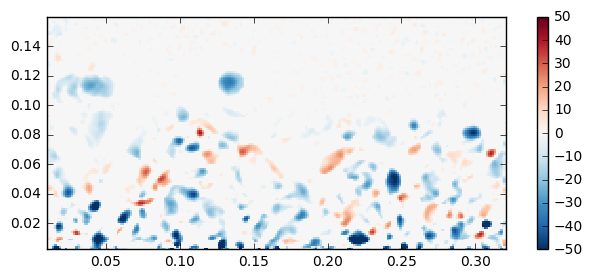

In [6]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(Swirl[:,:,frame]*Cond["delta"]/Cond["Utau"],X,Y,50,saveFolder = (saveFolder + '/Swirl_1.pdf'))

# Remove background noise

In [7]:
Noise = np.std(Swirl,axis=(2,1))
Noise = np.std(Noise[-5:])
print(Noise)

0.243960186268


In [8]:
SwirlFilt = Swirl.copy()    #think this should completely copy the list, allowing me to try things

#Swirl must be above a certain background value or it is zeroed
SwirlFilt[np.absolute(Swirl)<20*Noise] = 0

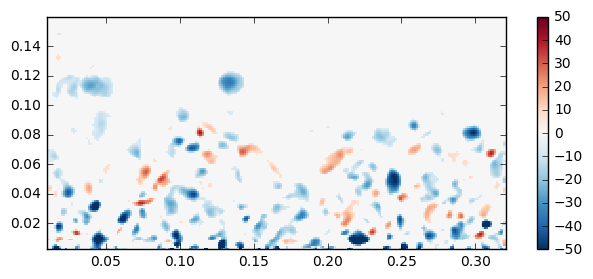

In [9]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame]*Cond["delta"]/Cond["Utau"],X,Y,50,saveFolder = (saveFolder + '/Swirl_2.pdf'))

# Normalize field by std

In [10]:
SwirlStd = np.std(Swirl,axis=(2,1))
#print(SwirlStd)

In [11]:
#Normalize field by the std of Swirl
SwirlFilt = SwirlFilt/SwirlStd.reshape(uSize[0],1,1) #match the SwirlStd length (123) with the correct index in Swirl (also 123)

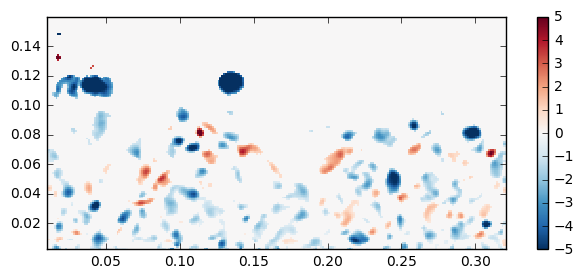

In [12]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5,saveFolder = (saveFolder + '/Swirl_3.pdf'))

In [13]:
SwirlFiltBackup = SwirlFilt.copy()

# Create thresholded field

In [14]:
SwirlFilt = SwirlFiltBackup.copy()    #think this should completely copy the list, allowing me to try things

#Then only keep those locations where swirls is greater than Thresh*SwirlStd
ThreshSTD = 1.5
SwirlFilt[np.absolute(SwirlFilt)<ThreshSTD] = 0
SwirlFiltPro = SwirlFilt.copy()
SwirlFiltPro[SwirlFiltPro>0] = 0
SwirlFiltRet = SwirlFilt.copy()
SwirlFiltRet[SwirlFiltRet<0] = 0

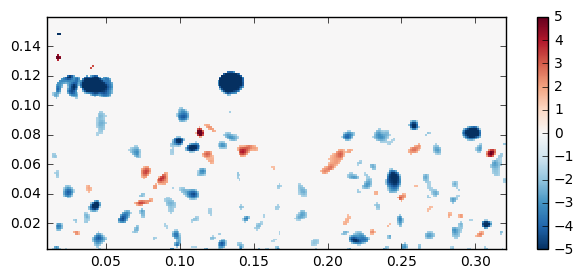

In [15]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5,saveFolder = (saveFolder + '/Swirl_4.pdf'))

# Find all blobs and filter for size


In [83]:
BoxSize = 10

PIVutils = reload(PIVutils)
ThreshPro = 35    #30 or 35 cause bug
[num_features_Pro,features_per_frame_Pro, labeled_array_Pro, cent_Pro] = PIVutils.findBlobs(SwirlFiltPro,ThreshPro,EdgeBound = BoxSize)

ThreshRet = 20    #30 or 35 cause bug
[num_features_Ret,features_per_frame_Ret, labeled_array_Ret, cent_Ret] = PIVutils.findBlobs(SwirlFiltRet,ThreshRet,EdgeBound = BoxSize)

There are  76730  features identified
A total of  13188  are larger than the threshold size
Of these 10645  are far enough away from edge of domain
There are  27229  features identified
A total of  3924  are larger than the threshold size
Of these 3489  are far enough away from edge of domain


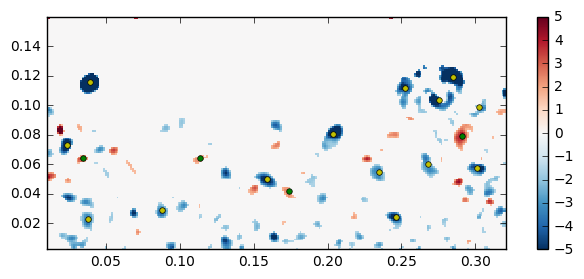

In [84]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5)

for i in range(features_per_frame_Pro[frame]):
    plt.plot(cent_Pro[frame][i][1]*scale+X[1,1],cent_Pro[frame][i][0]*scale+Y[1,1],'oy',markersize=4,markeredgecolor=None)
    
for i in range(features_per_frame_Ret[frame]):
    plt.plot(cent_Ret[frame][i][1]*scale+X[1,1],cent_Ret[frame][i][0]*scale+Y[1,1],'og',markersize=4,markeredgecolor=None)
    
f.savefig(saveFolder + '/Swirl_5.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

# Subtract mean profile or mean at centroid of swirl blob

In [85]:
#Calculate mean velocity profiles
Umean = np.nanmean(U,axis=(2,1))
Umean
Umean.shape
#print(Umean)

Umean = np.transpose(np.tile(Umean,(uSize[2],uSize[1],1)),(2,1,0))
#print(Umean.shape)

#Subtract mean velocity profiles from velocity fields
Uf = U - Umean;
Vf = V; #<--Mean in vertical is aprox zero
#Wf = W
del Umean

# Get thumbnails (Box = 21x21)

In [86]:
reload(PIVutils)

Ut, Vt, St= PIVutils.getThumbnails2D(Uf,Vf,Swirl,cent_Pro,BoxSize)
Ut2, Vt2, St2 = PIVutils.getThumbnails2D(Uf,Vf,Swirl,cent_Ret,BoxSize)

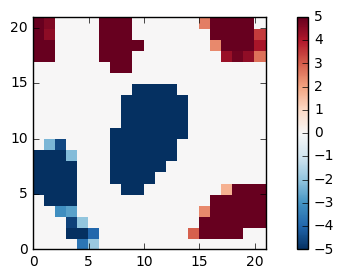

In [88]:
[f, ax] = PIVutils.plotScalarField(St[:,:,0],bound=5)

### Now do POD on the resulting thumbnails

In [89]:
#Set all NaNs to zero
Ut[np.isnan(Ut)] = 0
Vt[np.isnan(Vt)] = 0

uSize = Ut.shape

In [90]:
uAll = np.concatenate((Ut.reshape(uSize[0]*uSize[1],uSize[2]), Vt.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0)
#uAll.shape      

In [91]:
import modred as mr

num_modes = 50;
modes, eig_vals = mr.compute_POD_matrices_snaps_method(uAll, list(range(num_modes)))

In [92]:
menergy = eig_vals/np.sum(eig_vals)
menergy_sum = np.zeros(len(menergy))
for i in range(len(menergy)):
    menergy_sum[i] = np.sum(menergy[:i]);

In [93]:
reload(PODutils)
Umodes, Vmodes= PODutils.reconstructPODmodes(modes,uSize,num_modes,2)

In [94]:
#Calculate the mode coefficients
C = modes.transpose()*uAll
C = np.asarray(C)

### Plot modal energy and contribution total

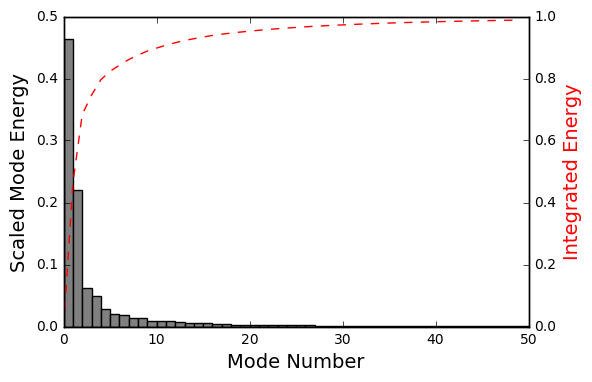

In [95]:
ind = np.arange(num_modes)  # the x locations for the groups
width = 1       # the width of the bars

f = plt.figure()
ax = plt.gca()
ax2 = plt.twinx()
rect = ax.bar(ind,menergy[:num_modes], width, color='gray')
line = ax2.plot(ind,menergy_sum[:num_modes],'--r')

ax.set_xlabel("Mode Number",fontsize=14)
ax.set_ylabel("Scaled Mode Energy",fontsize=14)
ax2.set_ylabel("Integrated Energy",fontsize=14,color='red')

f.savefig(saveFolder + '/ModeEnergy-Pro-10.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Plot some modes

/Users/Owen/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


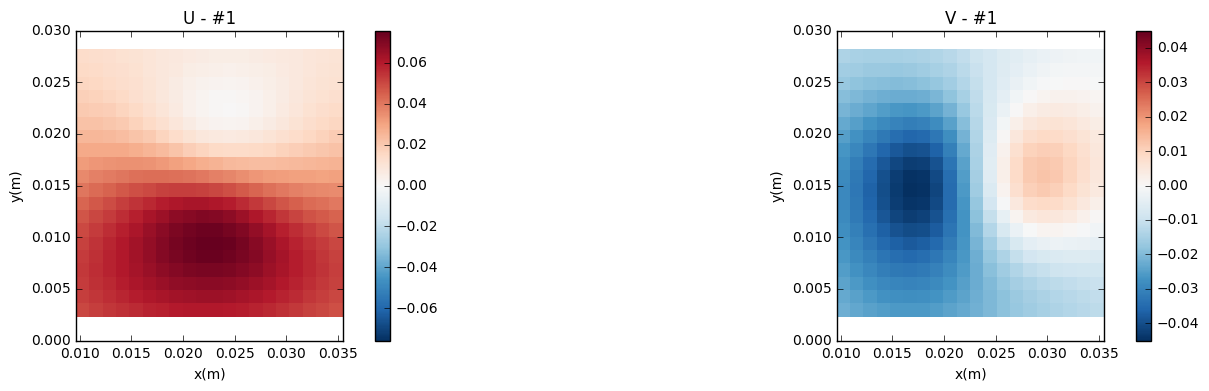

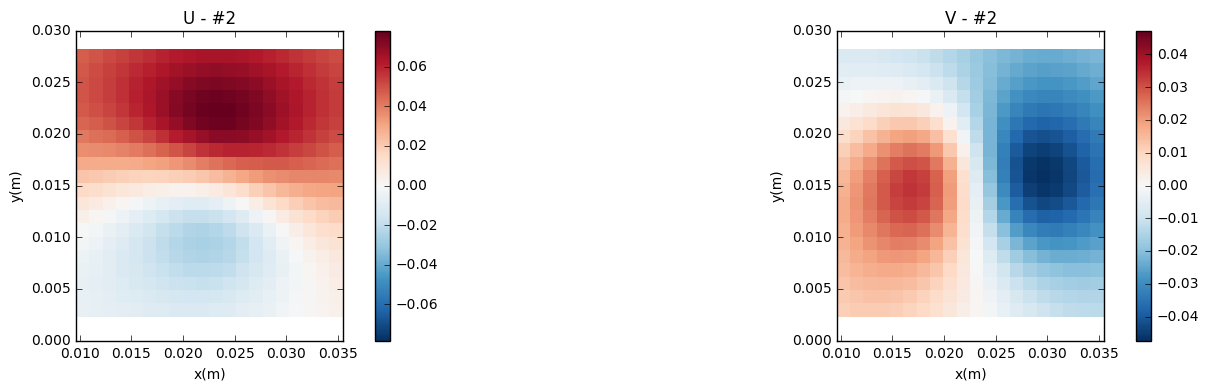

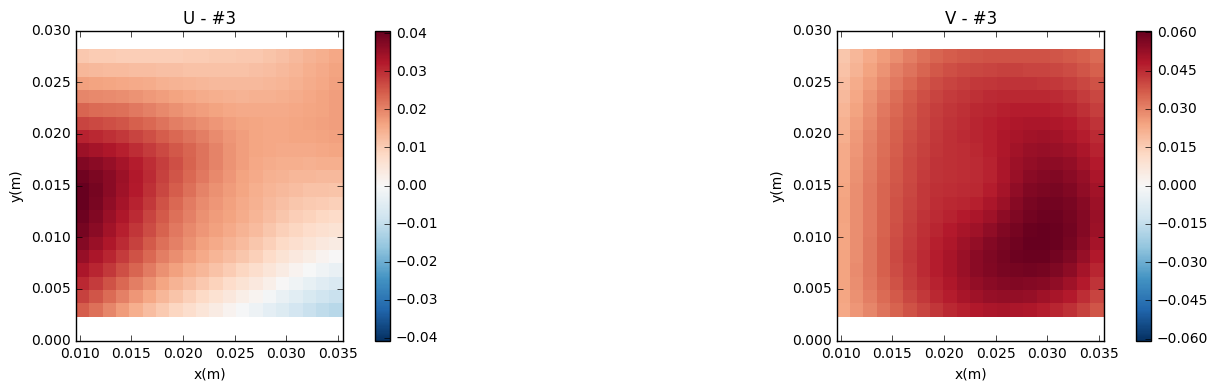

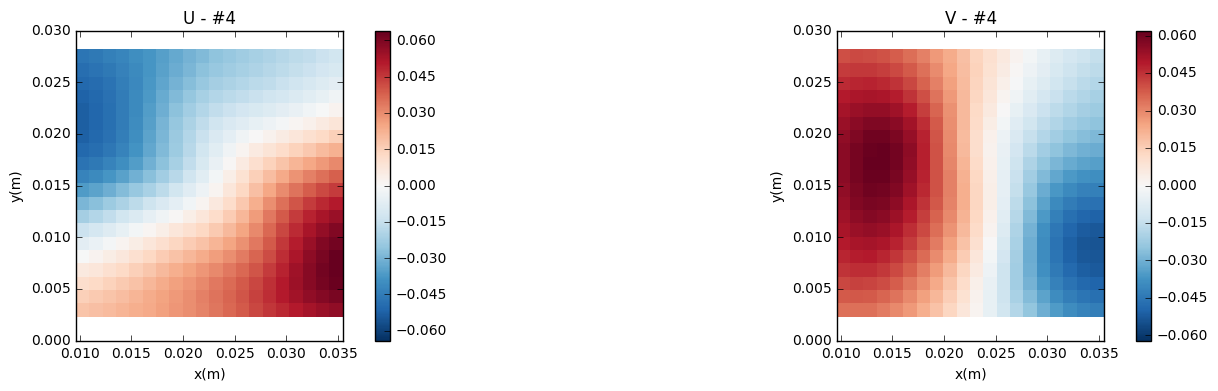

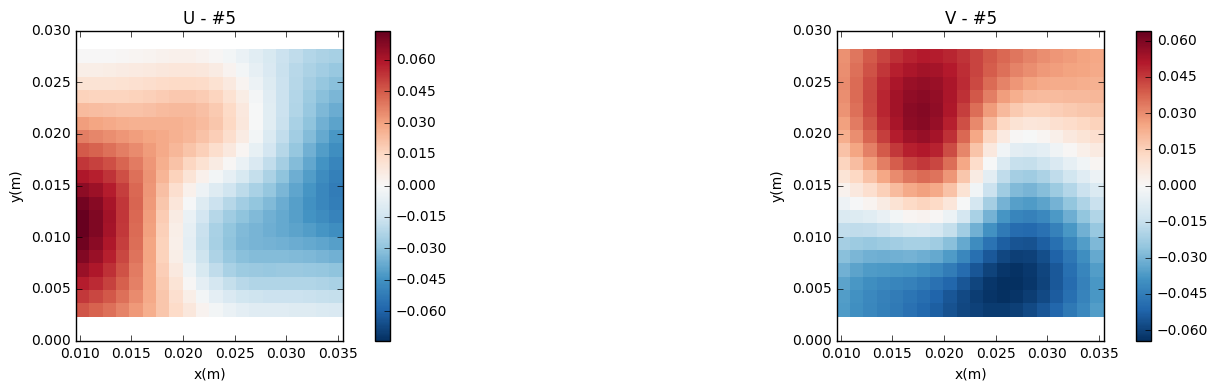

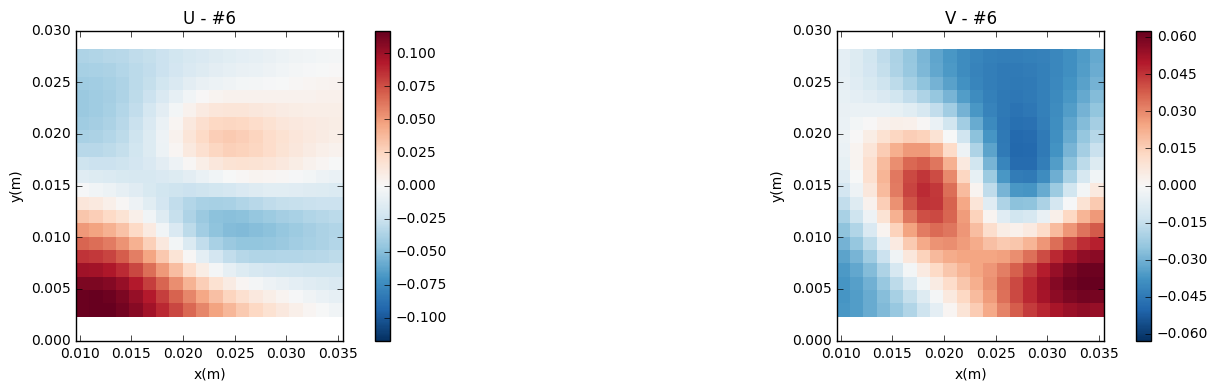

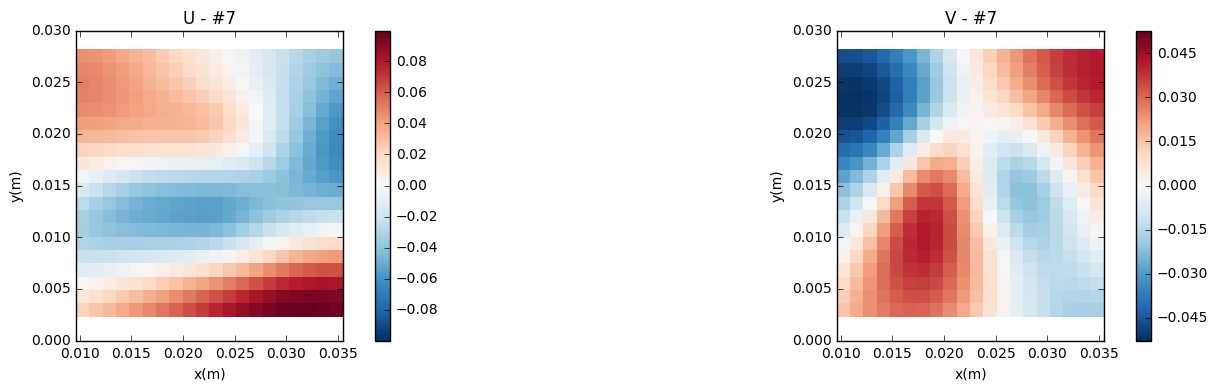

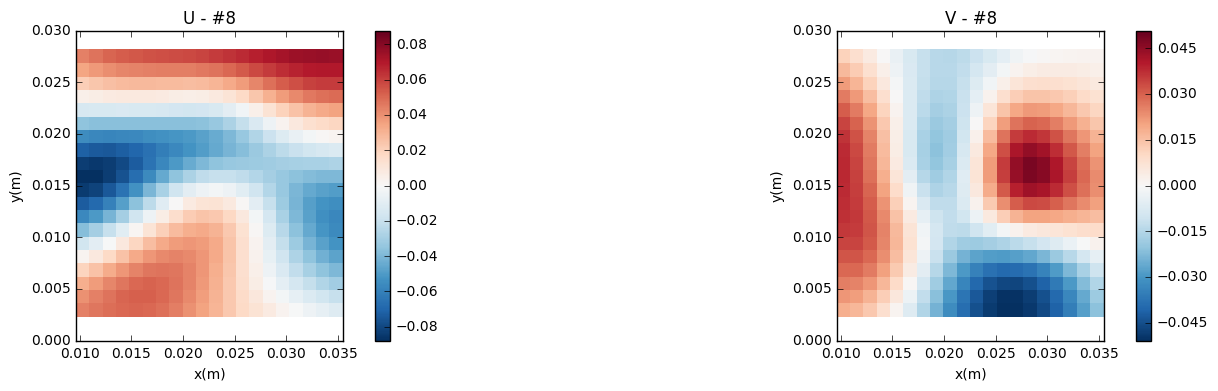

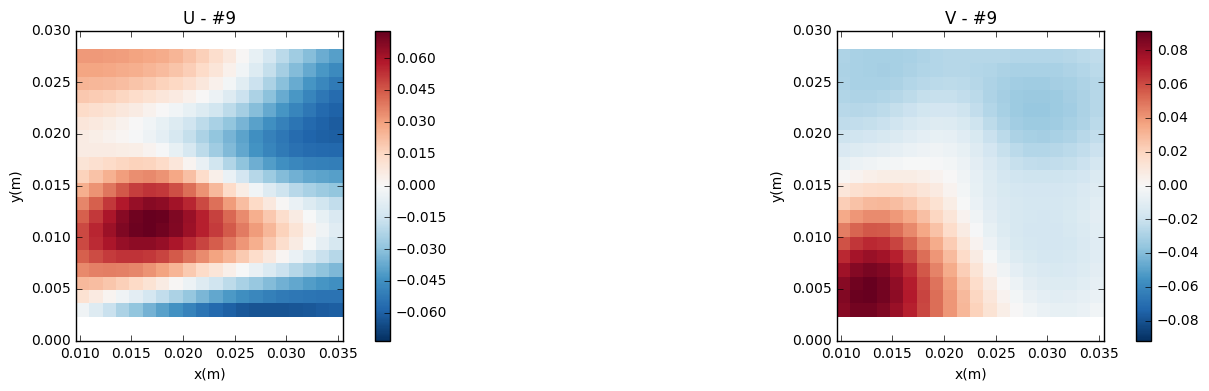

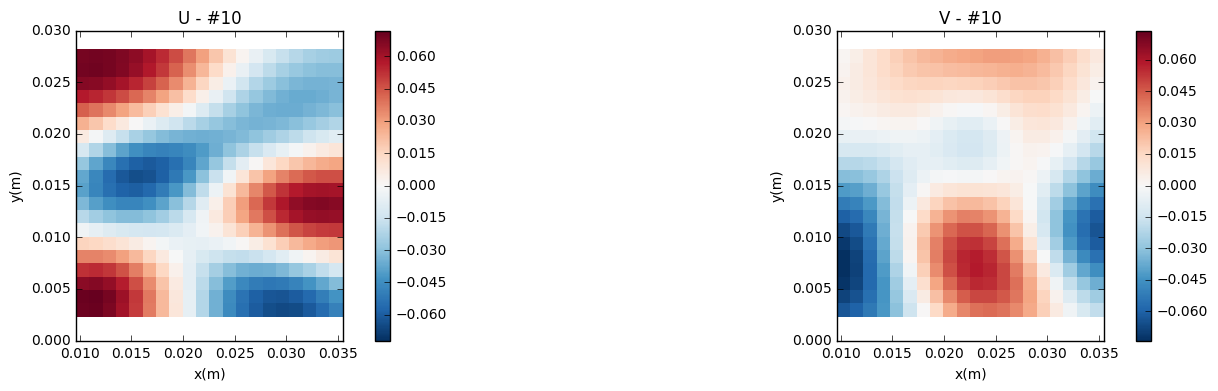

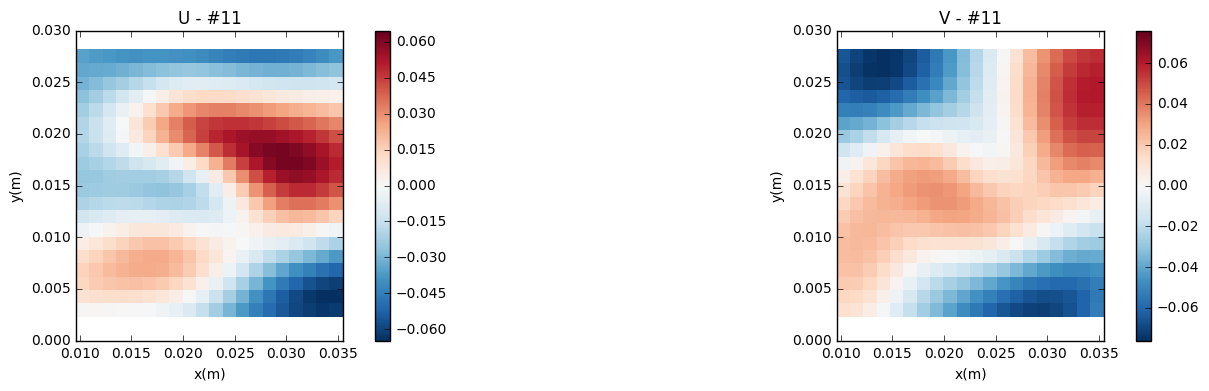

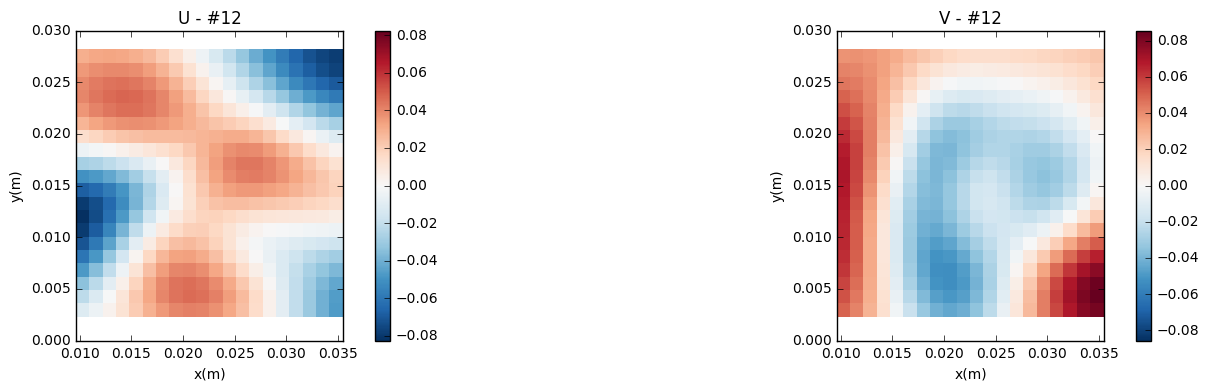

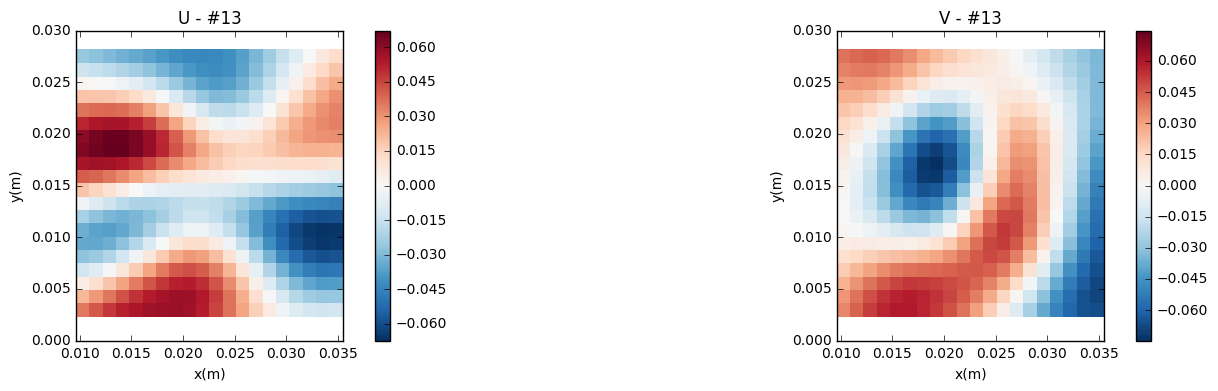

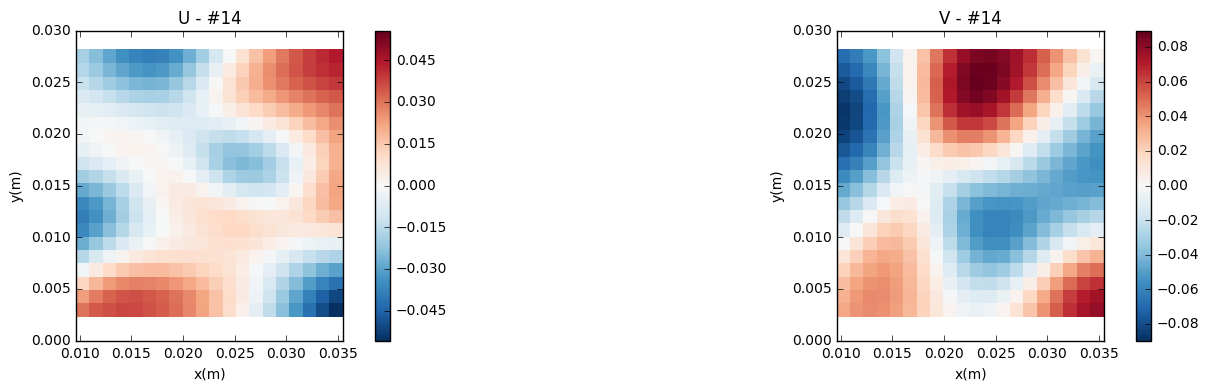

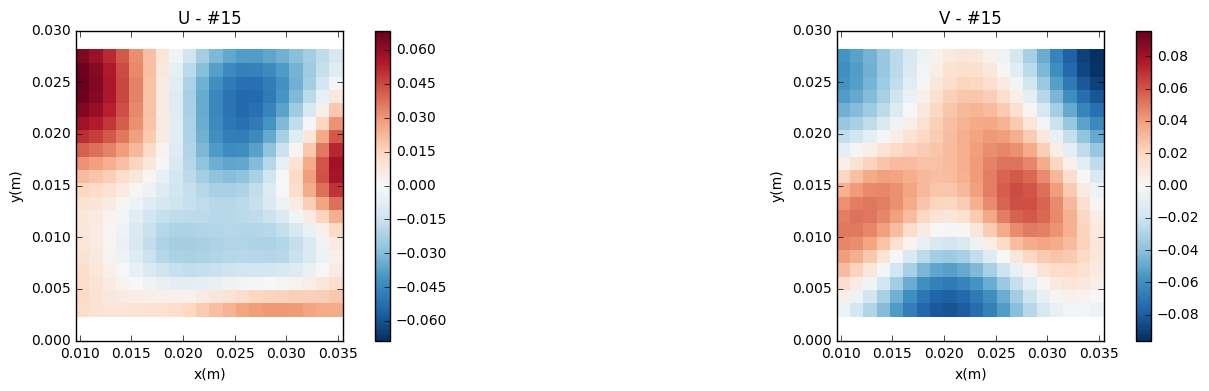

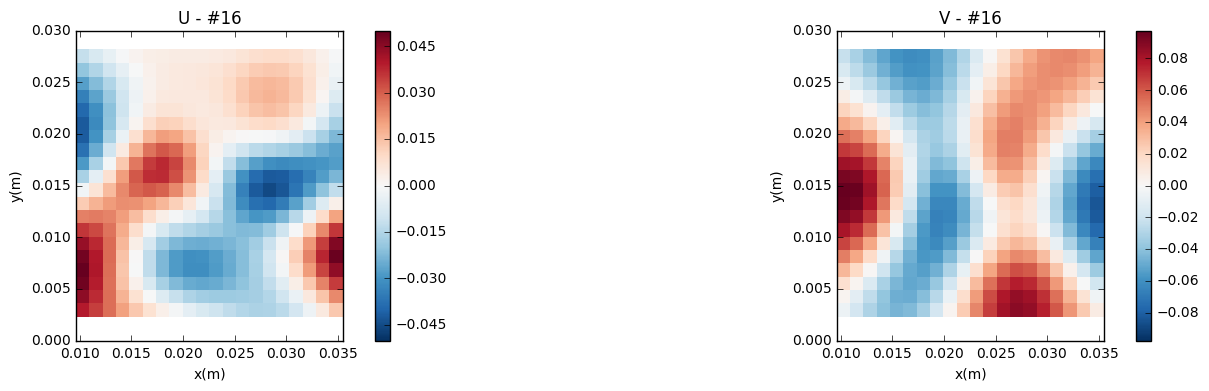

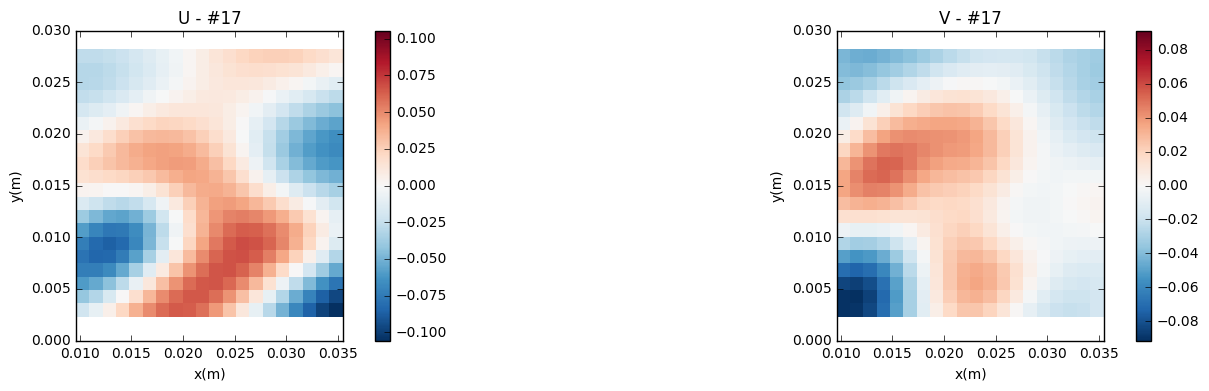

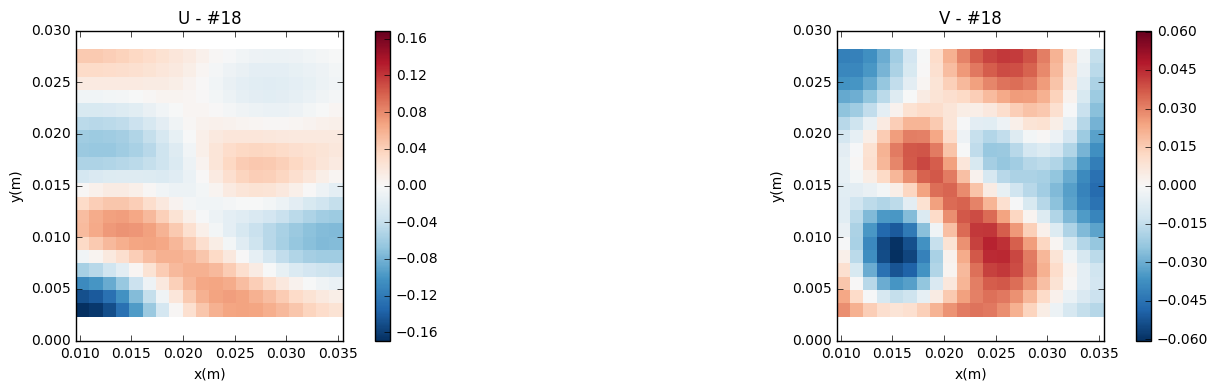

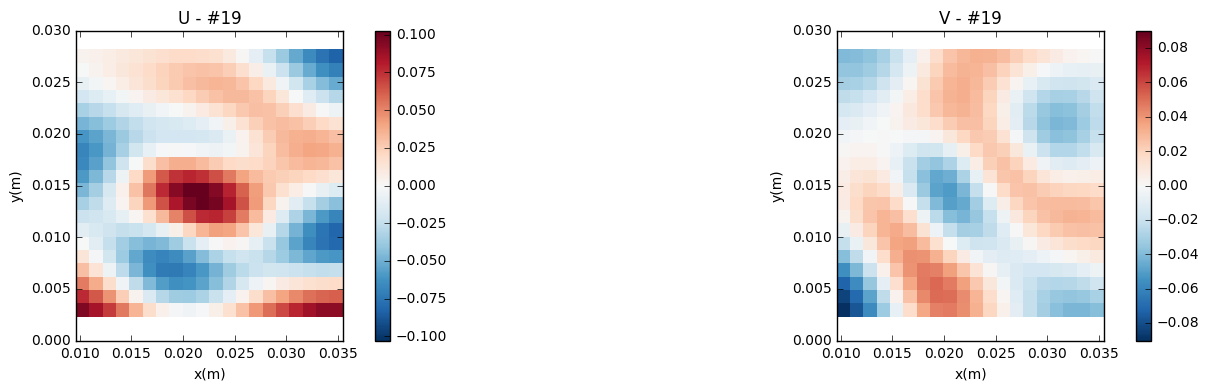

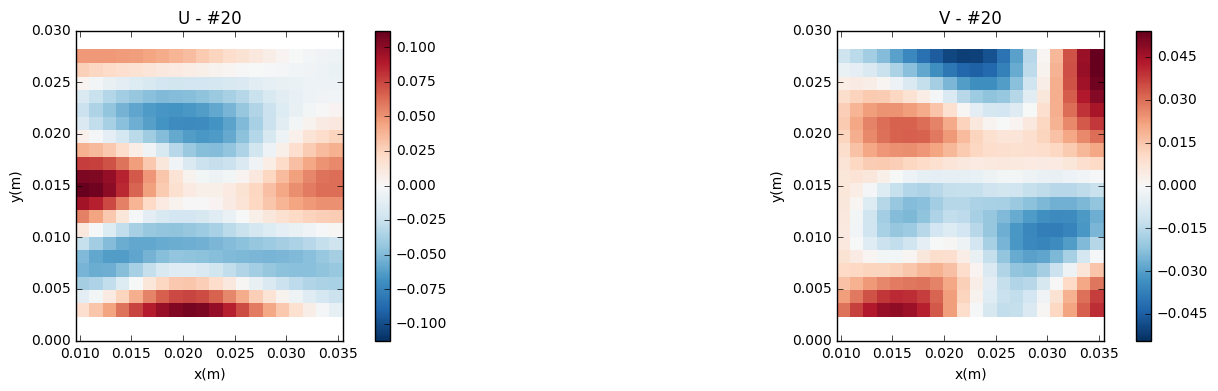

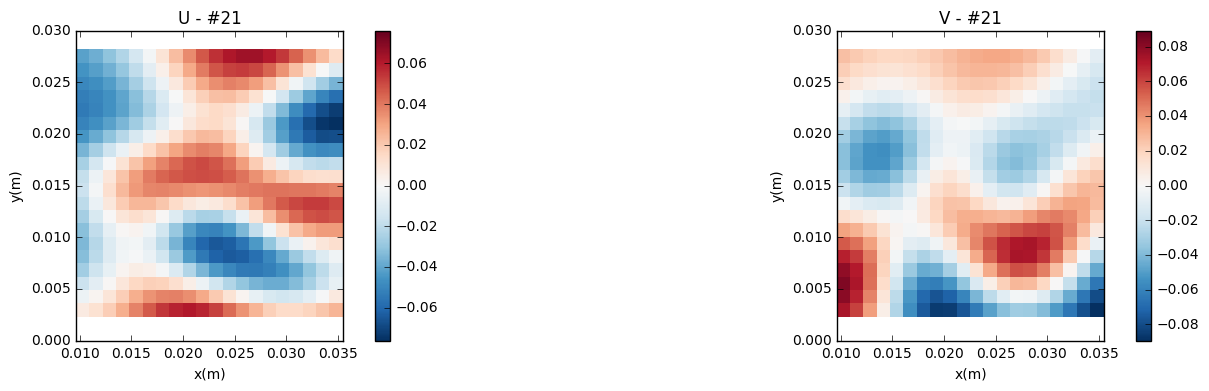

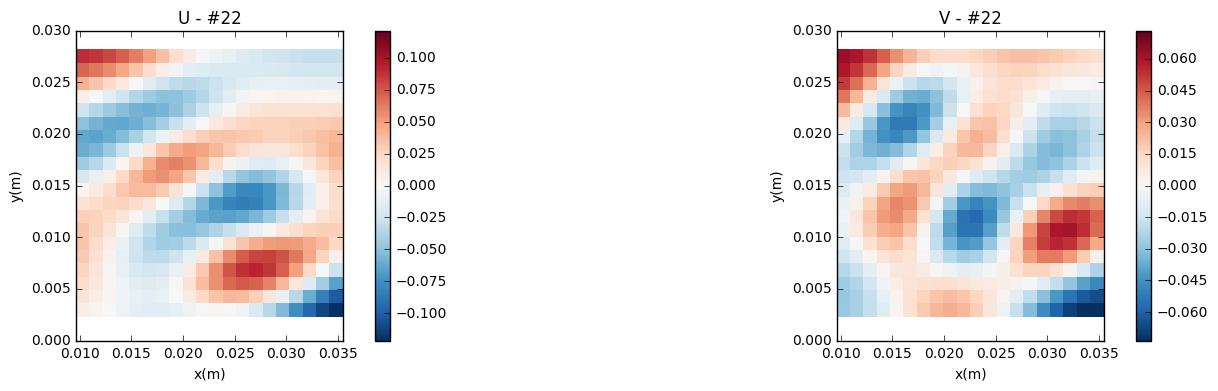

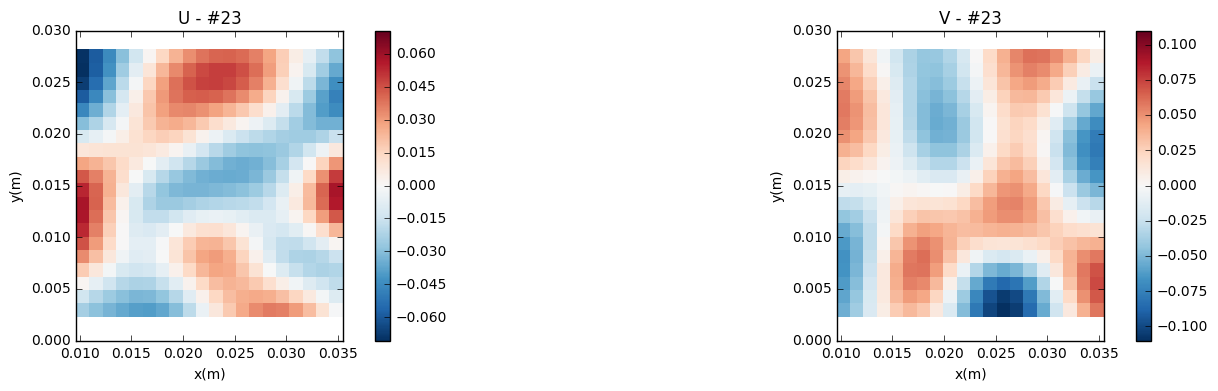

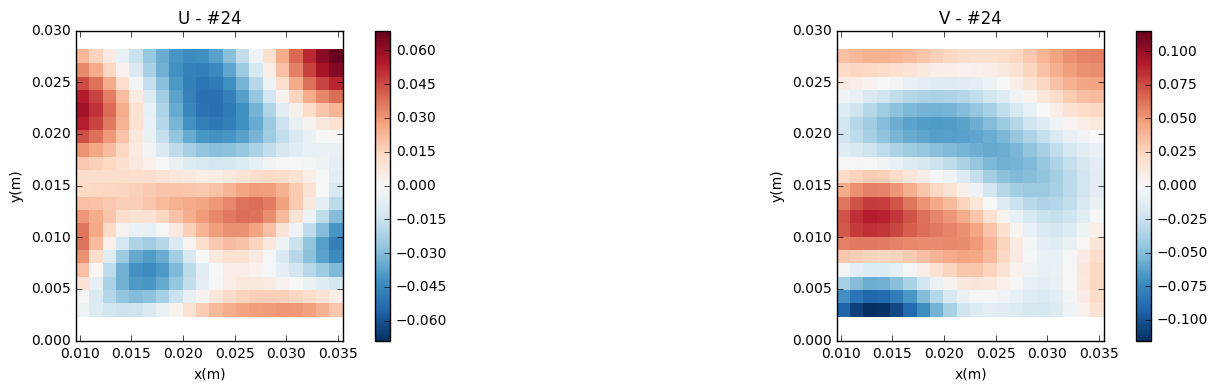

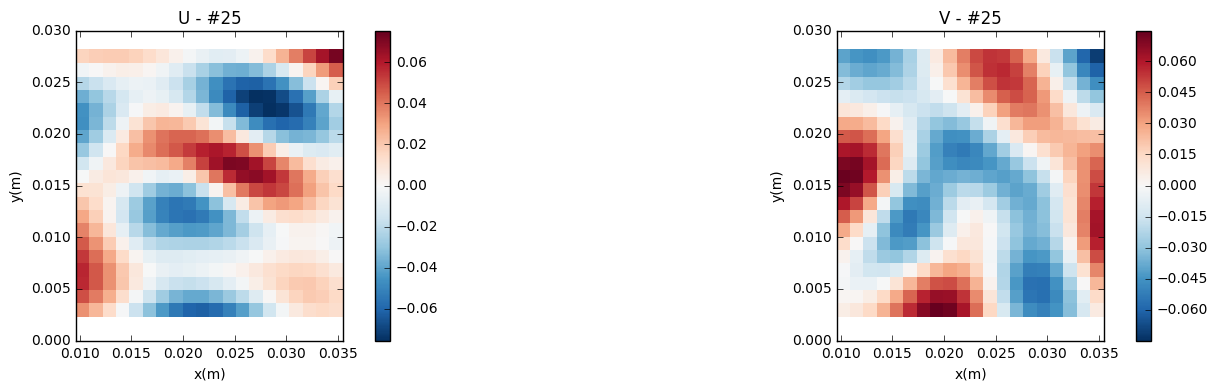

In [96]:
import PODutils
PODutils.plotPODmodes2D(X[:2*BoxSize+1,:2*BoxSize+1],Y[:2*BoxSize+1,:2*BoxSize+1],Umodes,Vmodes,list(range(25)),saveFolder)

### Plot the variation of the coefficients

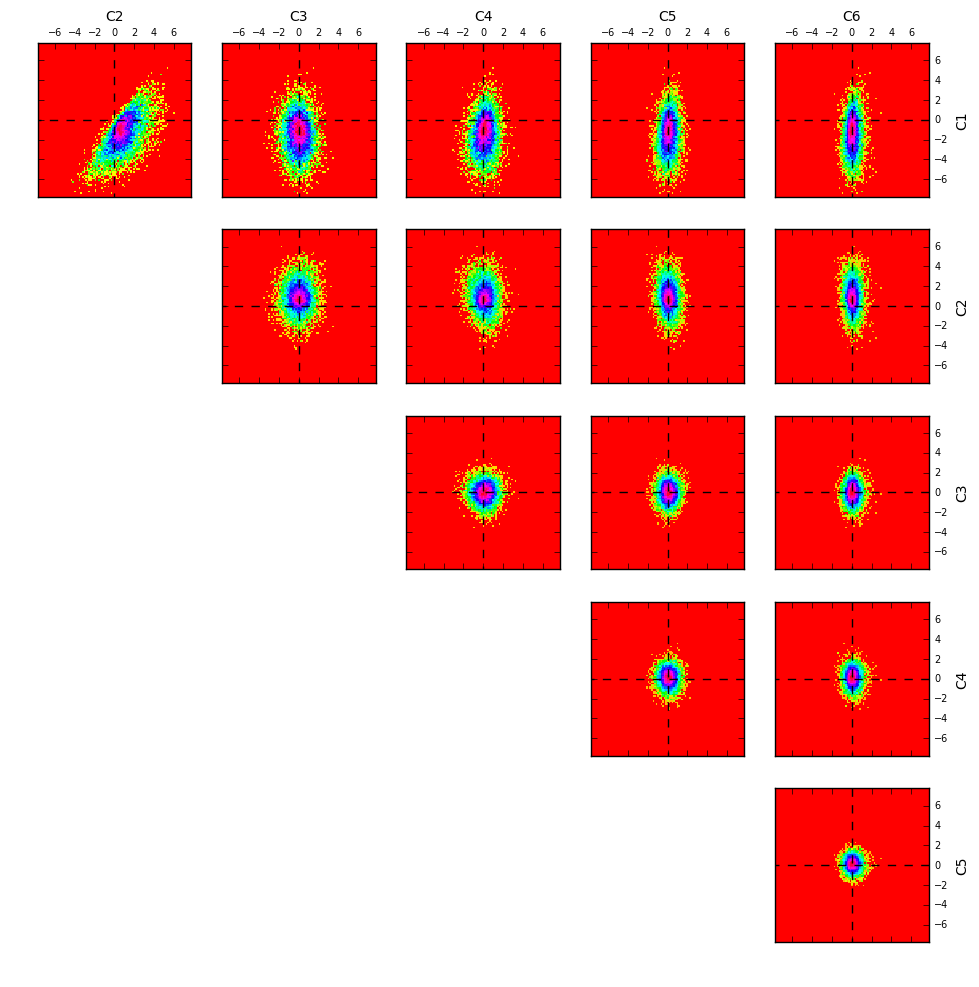

In [97]:
reload(PODutils)
PODutils.plotPODcoeff(C,list(range(6)),100,8,1,saveFolder)

In [98]:
ind = 0
ypos =[]
for i in range(len(cent_Pro)):
    for j in range(len(cent_Pro[i])):
        ypos = np.concatenate([ypos, [Y[cent_Pro[i][j][0],1]]])
        
        #[ind] = cent_Pro[i][j][0]*scale+Y[1,1]
        #ind+=1


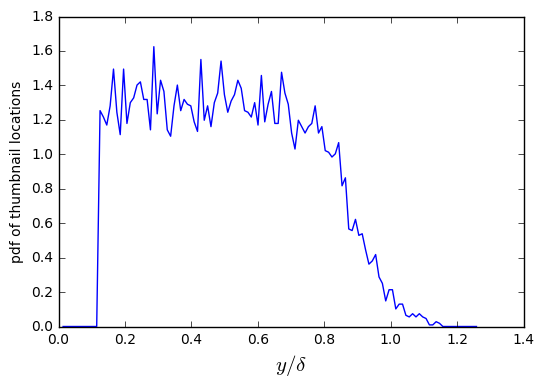

In [99]:
# Calcualte pdf of wall-normal locations
xedges = Y[:,0]/Cond["delta"]
xedges = np.concatenate([[xedges[0]-(xedges[1]-xedges[0])],xedges, [xedges[-1]+xedges[-1]-xedges[-2]]])
p, x = np.histogram(ypos/Cond["delta"], xedges,normed=True)
x = x[:-1] + (x[1] - x[0])/2 
plt.plot(x, p)
plt.xlabel('$y/\delta$', fontsize=15)
plt.ylabel('pdf of thumbnail locations')

plt.savefig(saveFolder + '/PDFswirl-Pro-10.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

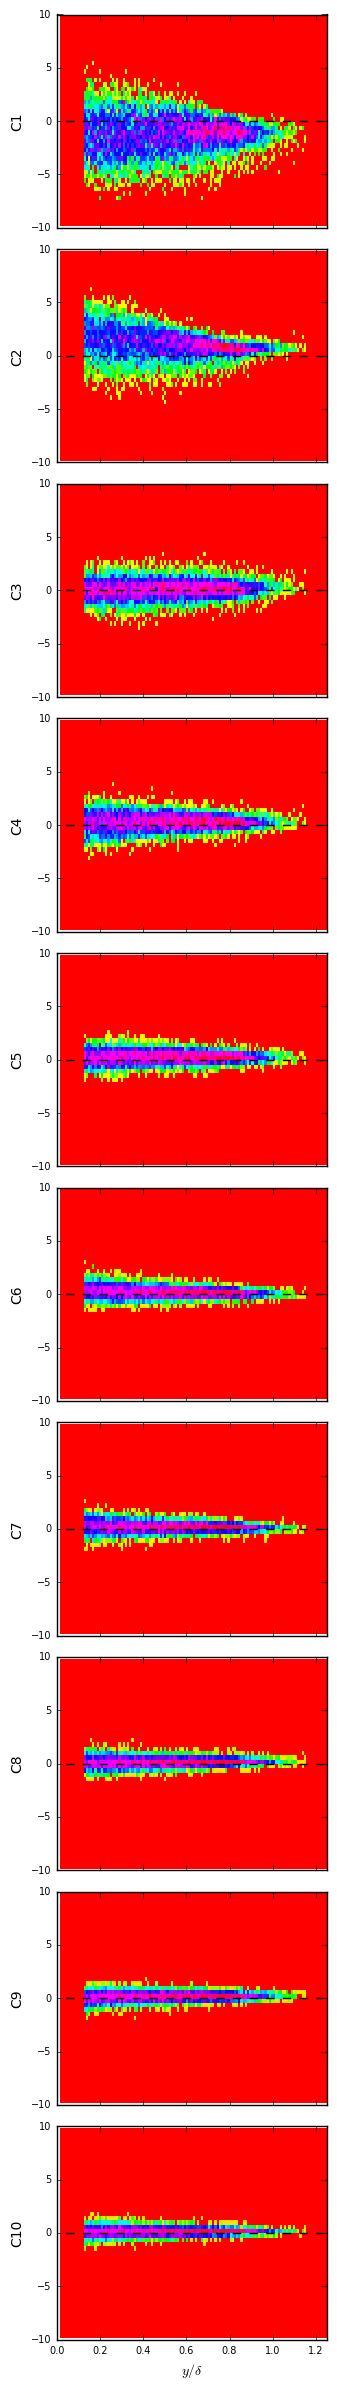

In [100]:
reload(PODutils)
C2 = C.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T/Cond["delta"], C2], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(10)),50,10,1,saveFolder)

In [101]:
del C,C2,modes,Umodes,Vmodes

# Do POD on random set of data

In [103]:
reload(PIVutils)
BoxSize = 10

Ut, Vt, St = PIVutils.getRandomThumbnails2D(Uf,Vf,Swirl,num_features_Pro,BoxSize)

In [104]:
#Set all NaNs to zero
Ut[np.isnan(Ut)] = 0
Vt[np.isnan(Vt)] = 0

uSize = Ut.shape

In [105]:
uAll = np.concatenate((Ut.reshape(uSize[0]*uSize[1],uSize[2]), Vt.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0)
#uAll.shape      

In [106]:
import modred as mr

num_modes = 50;
modes, eig_vals = mr.compute_POD_matrices_snaps_method(uAll, list(range(num_modes)))

In [107]:
menergy = eig_vals/np.sum(eig_vals)
menergy_sum = np.zeros(len(menergy))
for i in range(len(menergy)):
    menergy_sum[i] = np.sum(menergy[:i]);

In [108]:
reload(PODutils)
Umodes, Vmodes= PODutils.reconstructPODmodes(modes,uSize,num_modes,2)

In [109]:
#Calculate the mode coefficients
C = modes.transpose()*uAll
C = np.asarray(C)

### Plot modal energy and contribution total

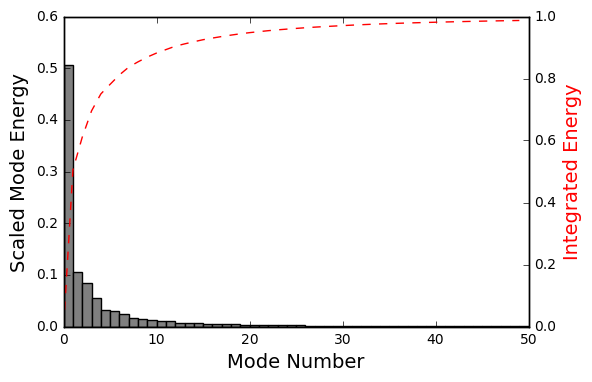

In [110]:
ind = np.arange(num_modes)  # the x locations for the groups
width = 1       # the width of the bars

f = plt.figure()
ax = plt.gca()
ax2 = plt.twinx()
rect = ax.bar(ind,menergy[:num_modes], width, color='gray')
line = ax2.plot(ind,menergy_sum[:num_modes],'--r')

ax.set_xlabel("Mode Number",fontsize=14)
ax.set_ylabel("Scaled Mode Energy",fontsize=14)
ax2.set_ylabel("Integrated Energy",fontsize=14,color='red')

f.savefig(saveFolder + '/ModeEnergy-Pro-10.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Plot some modes

/Users/Owen/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


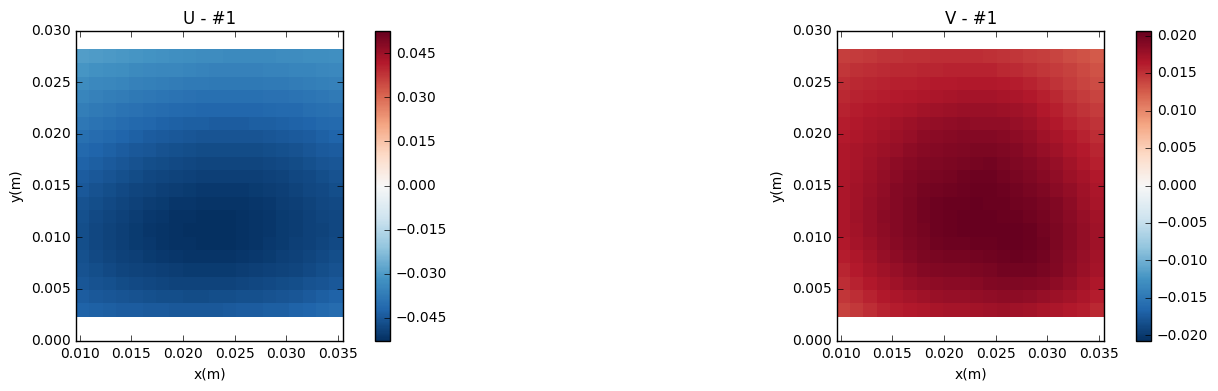

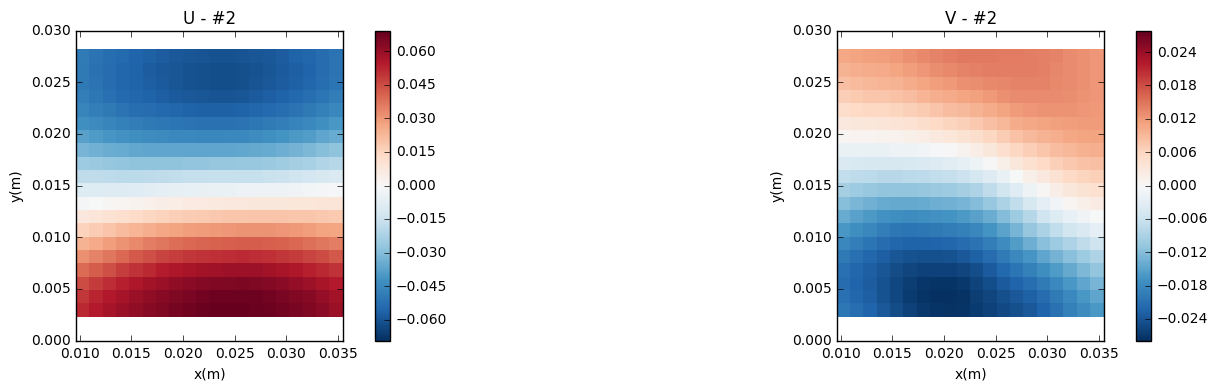

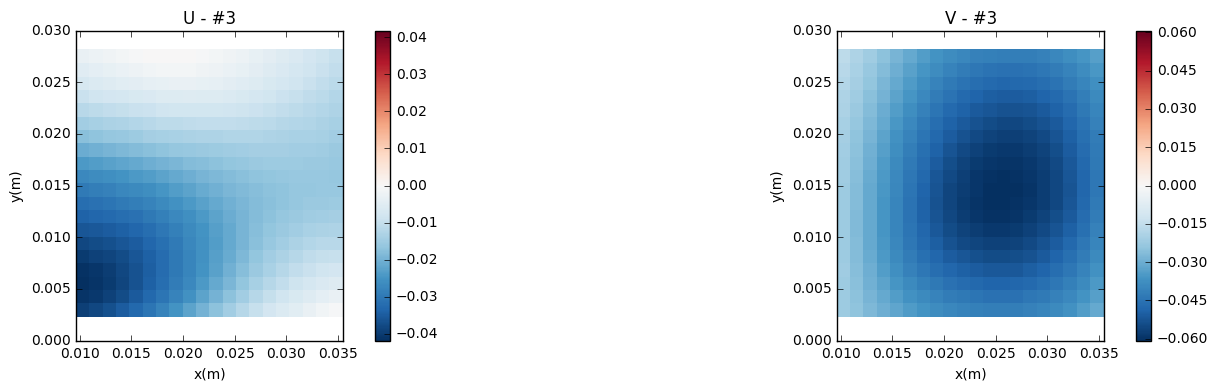

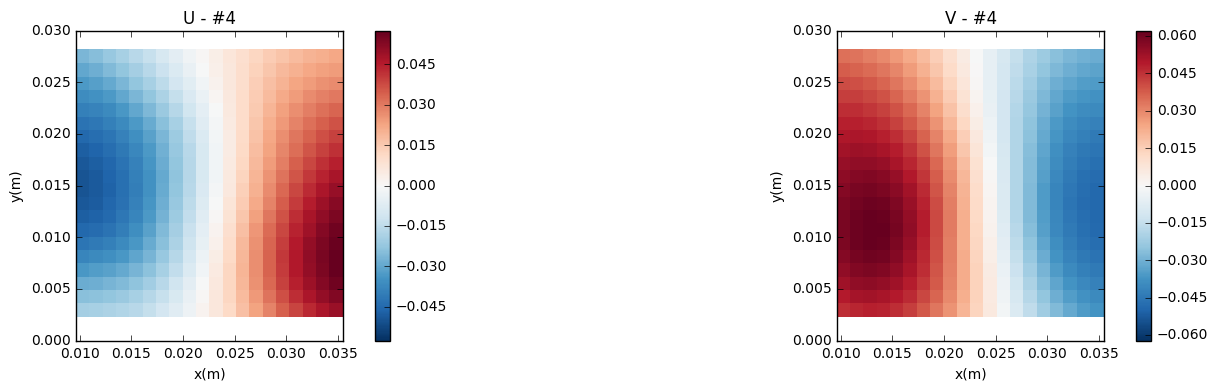

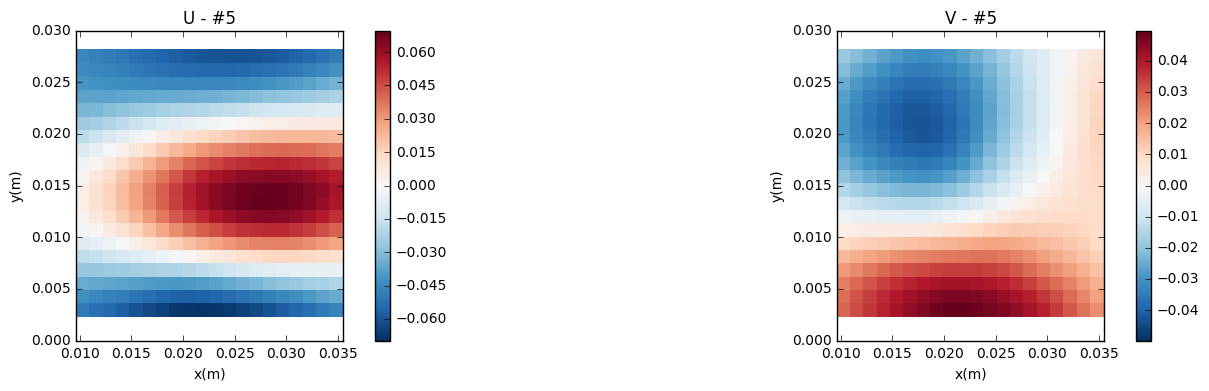

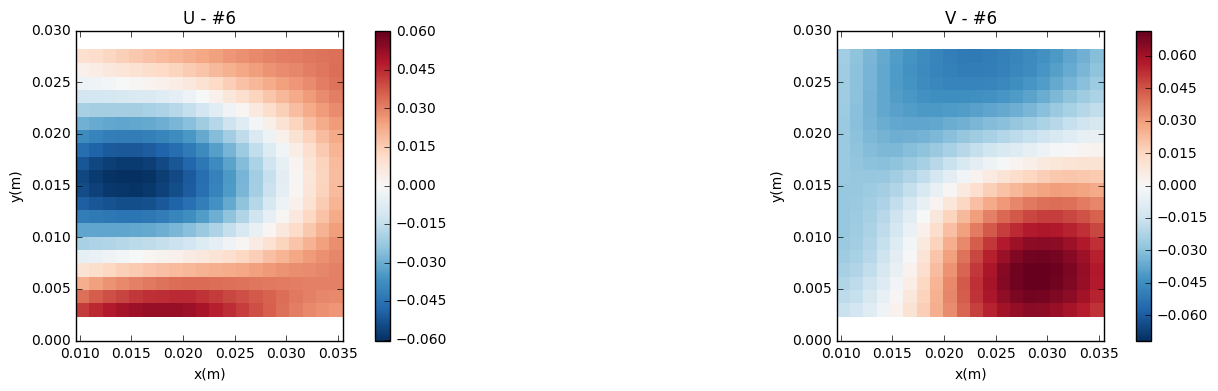

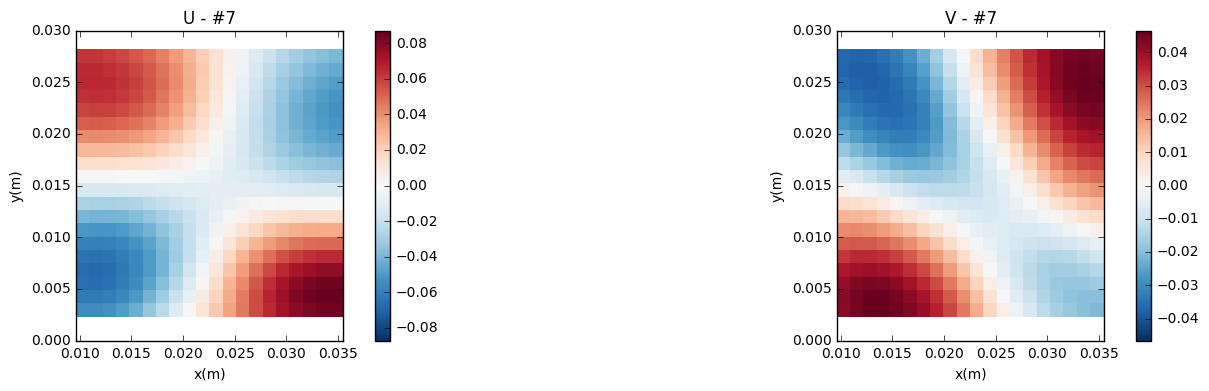

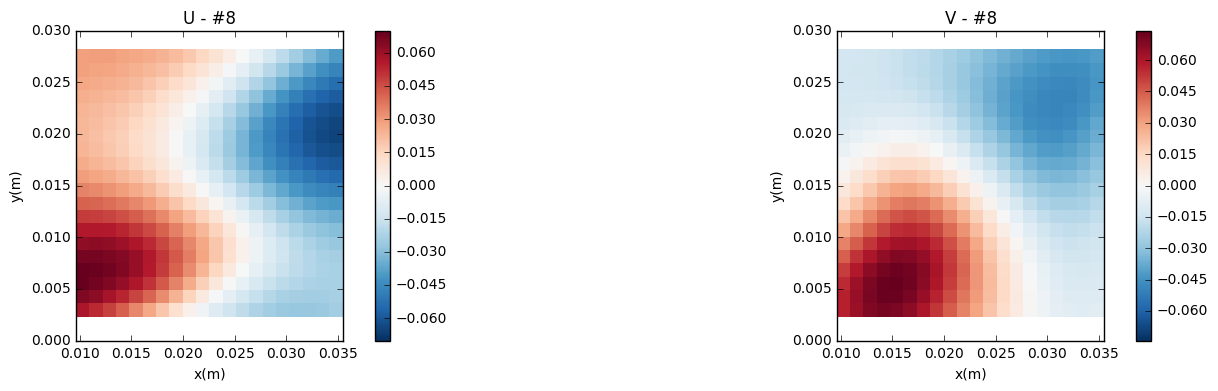

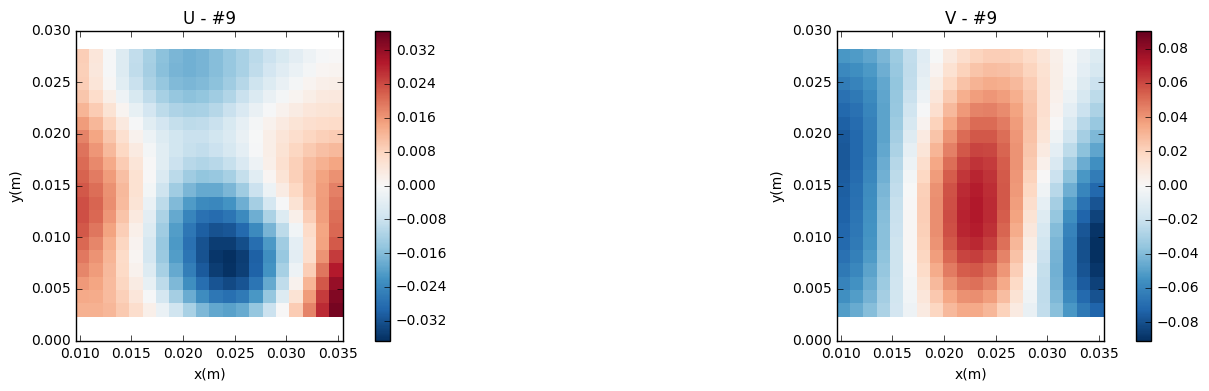

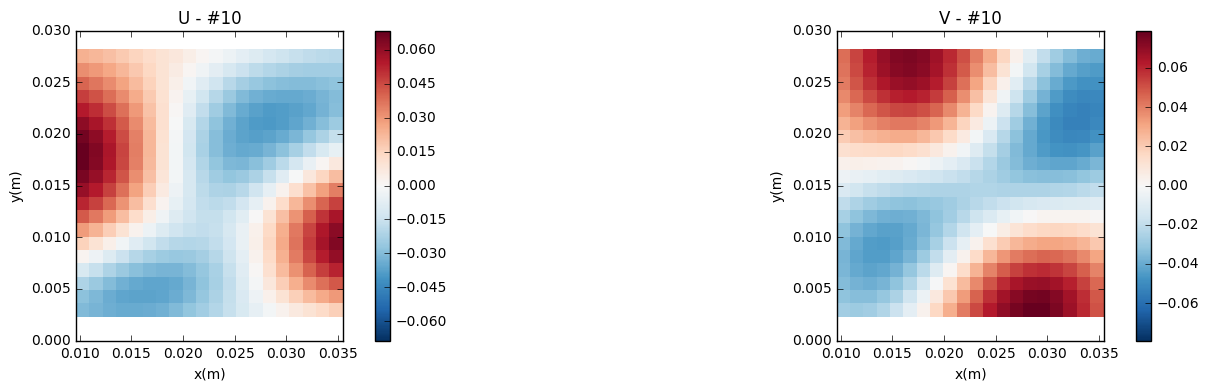

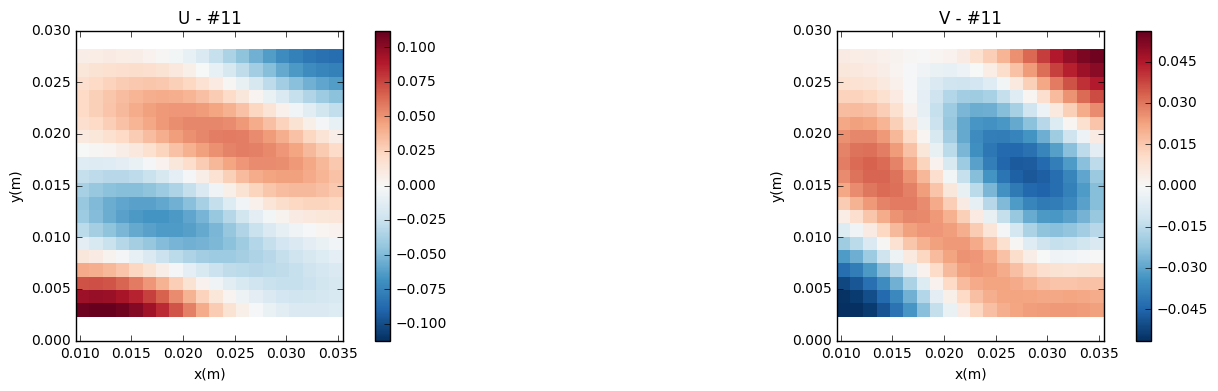

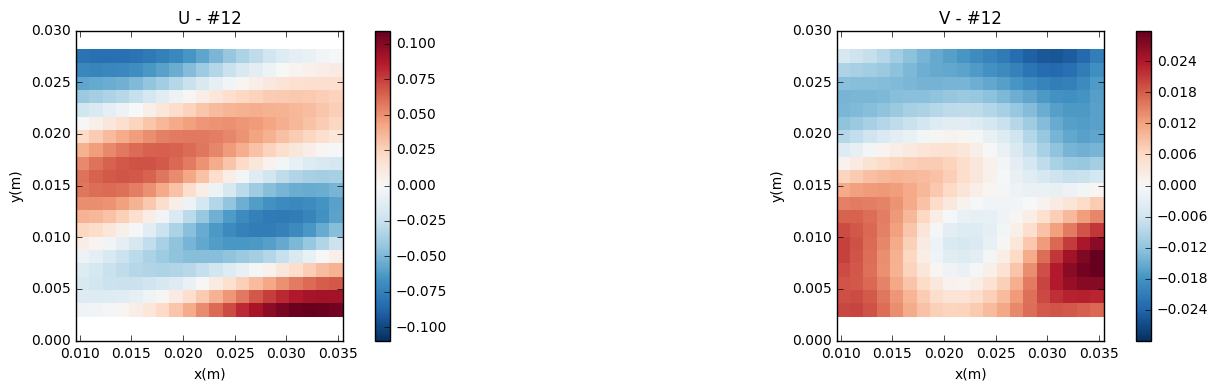

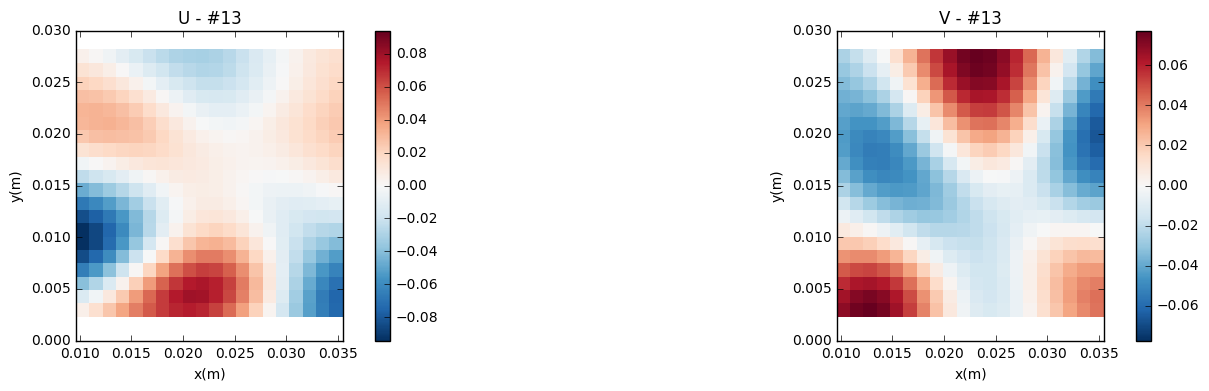

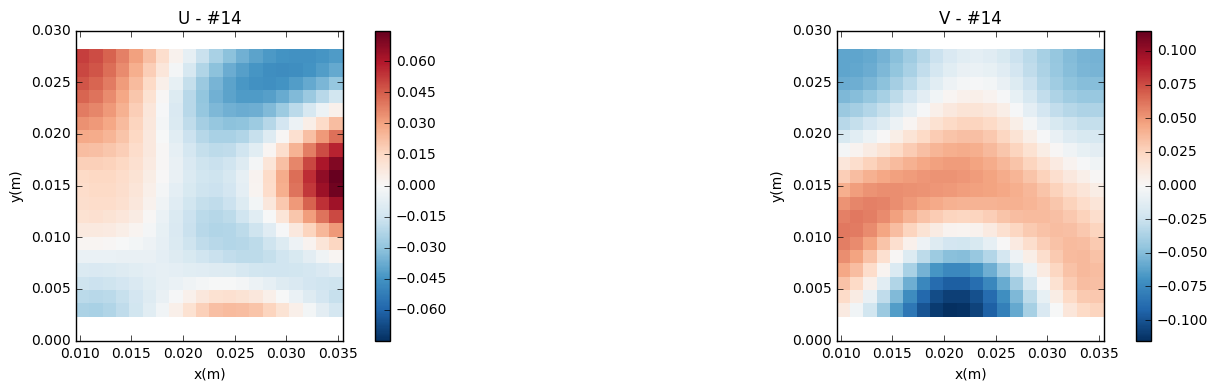

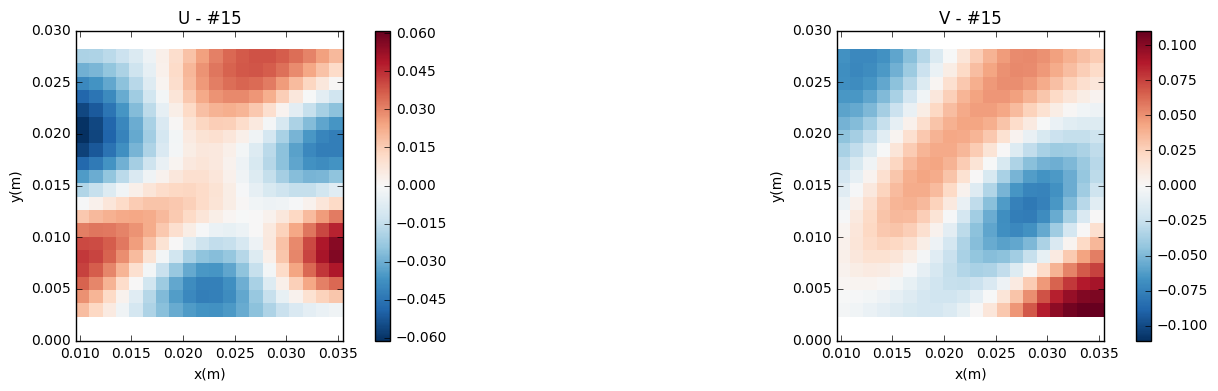

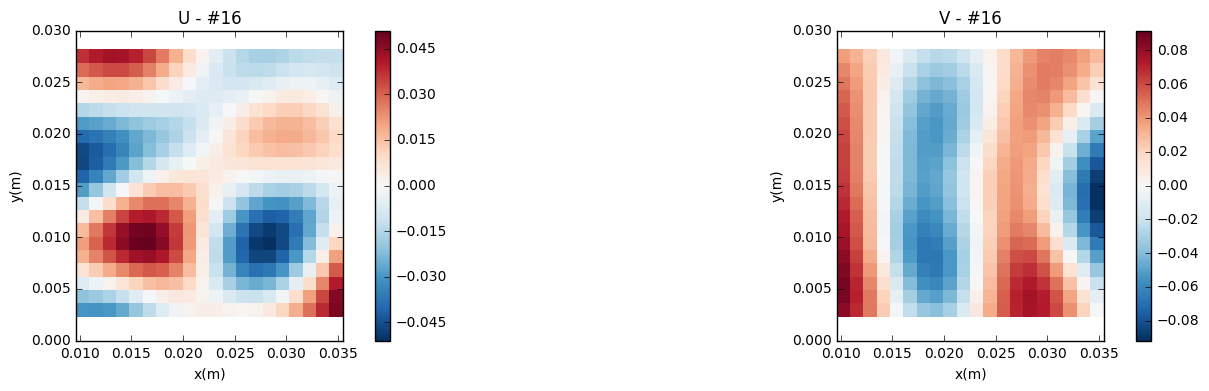

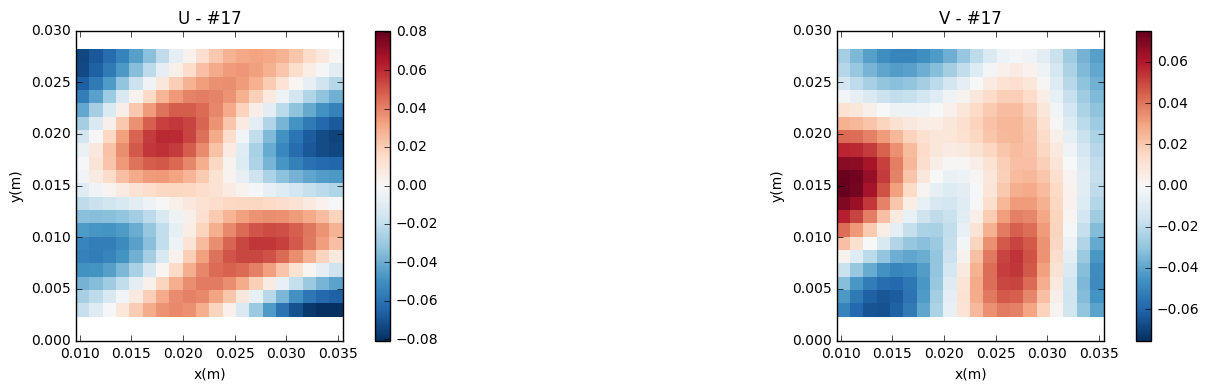

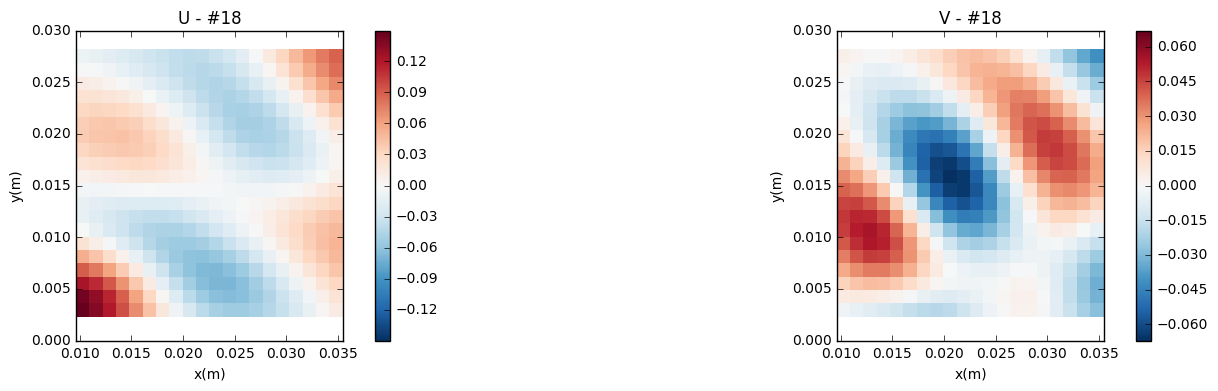

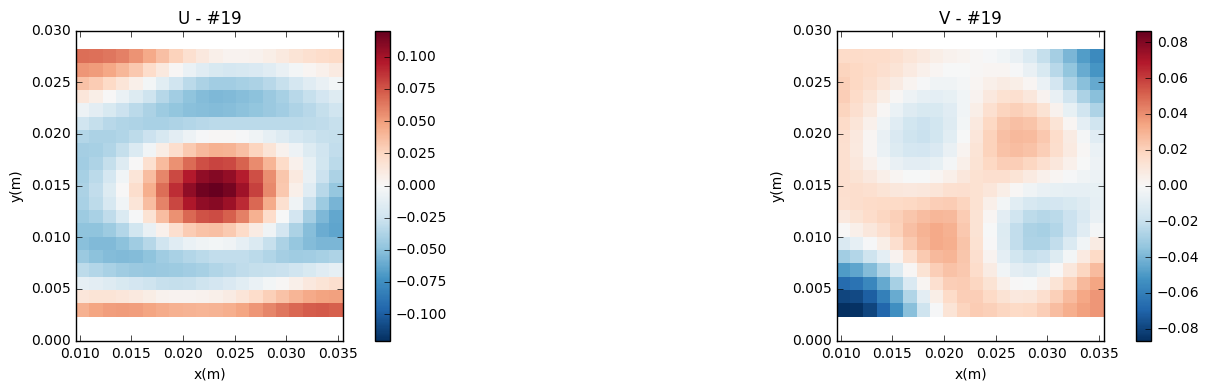

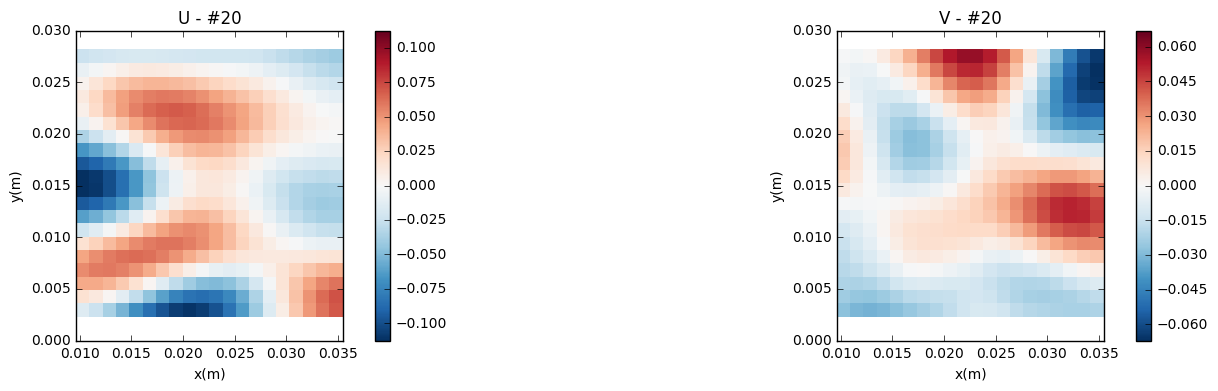

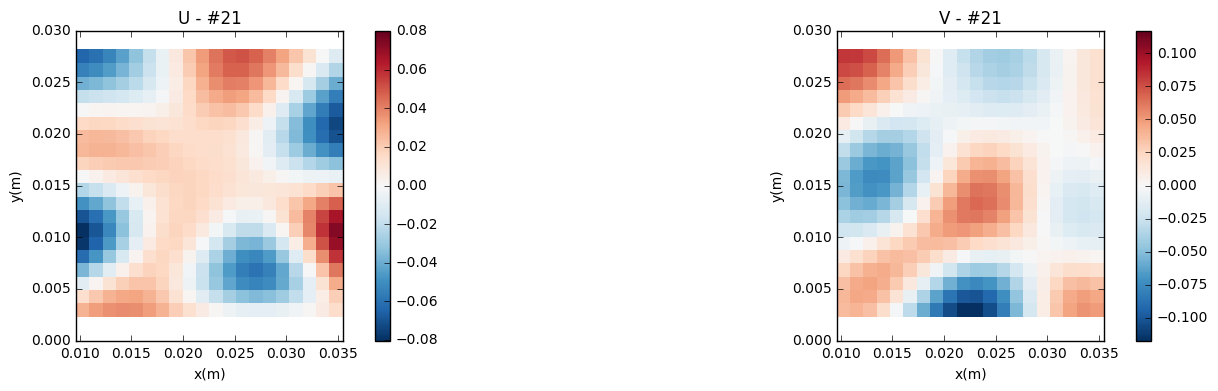

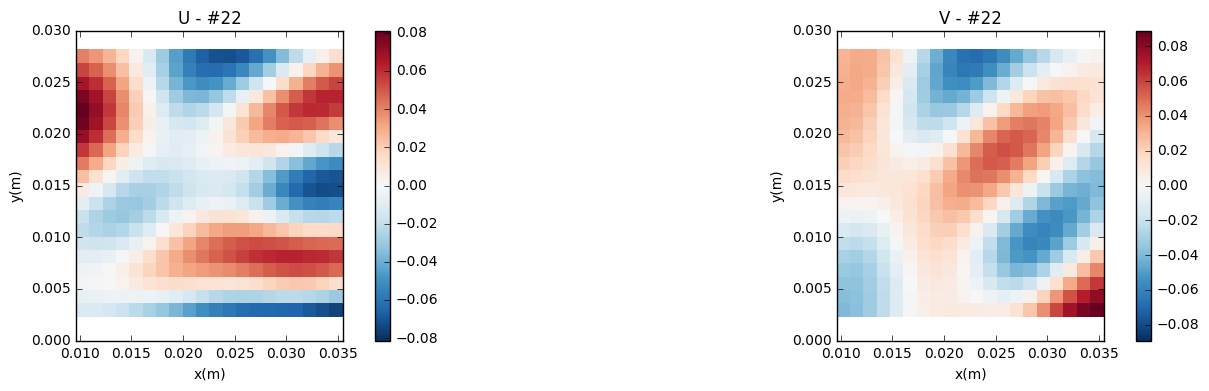

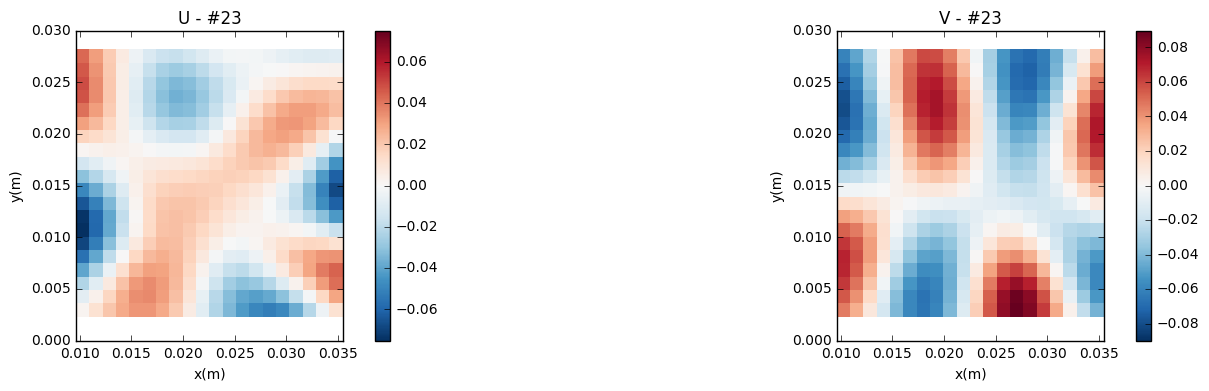

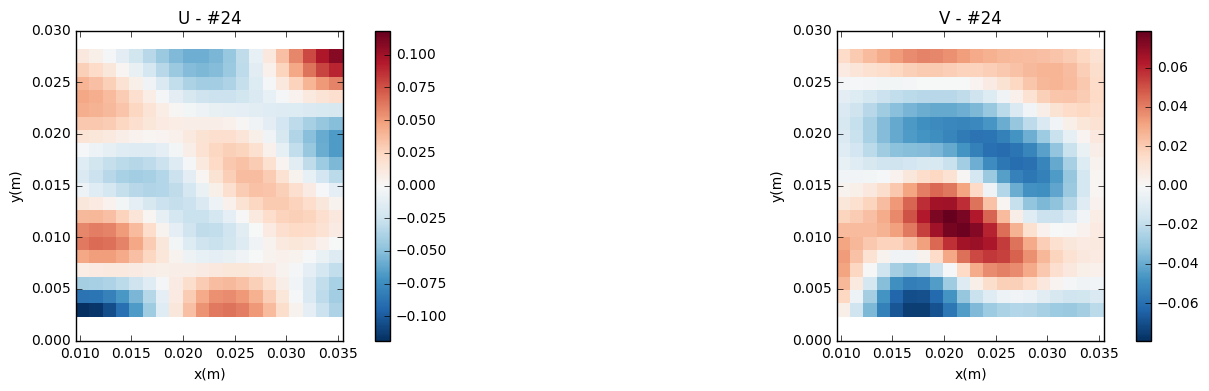

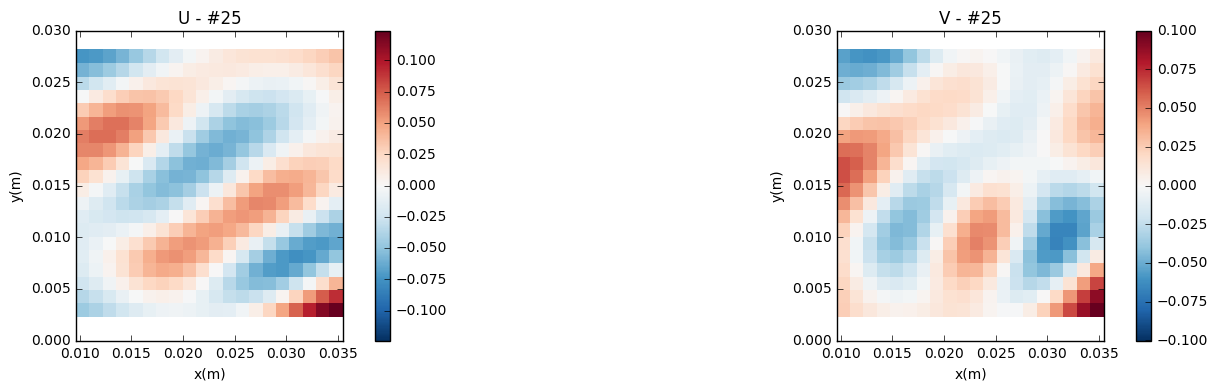

In [111]:
import PODutils
PODutils.plotPODmodes2D(X[:2*BoxSize+1,:2*BoxSize+1],Y[:2*BoxSize+1,:2*BoxSize+1],Umodes,Vmodes,list(range(25)),saveFolder)

### Plot the variation of the coefficients

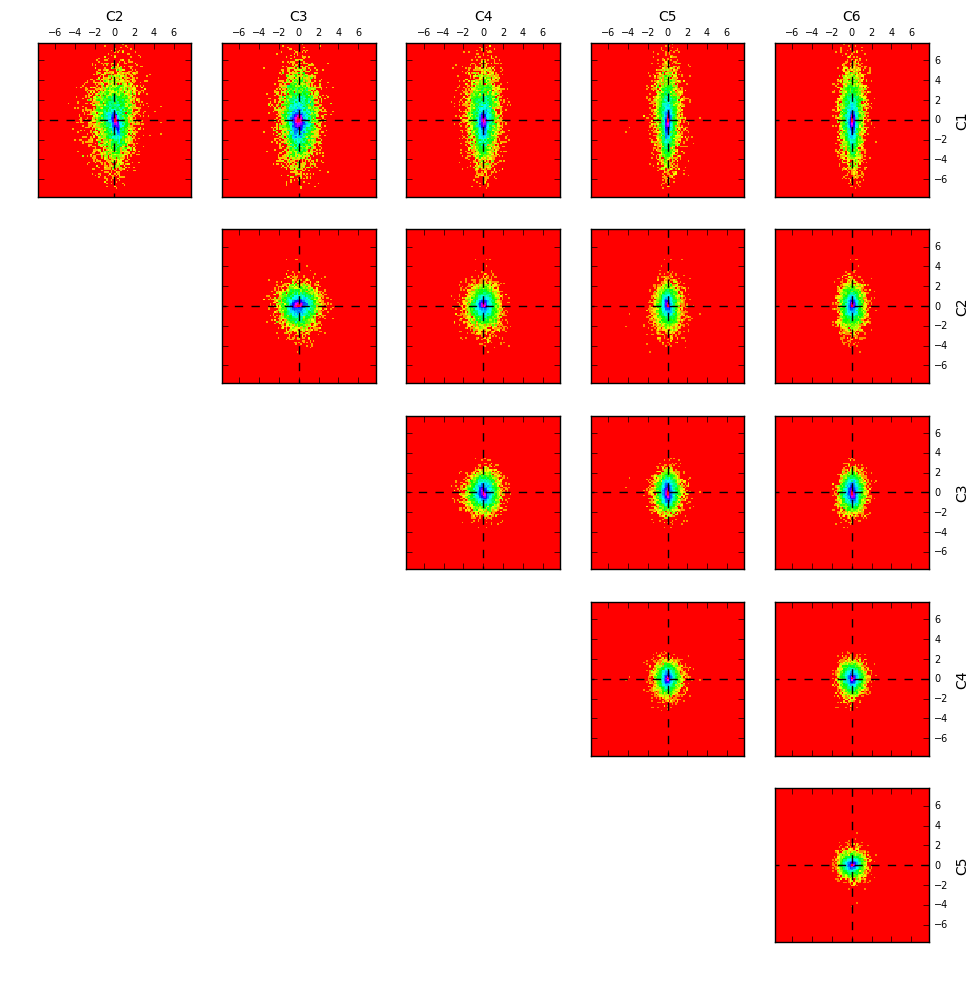

In [112]:
reload(PODutils)
PODutils.plotPODcoeff(C,list(range(6)),100,8,1,saveFolder)

In [113]:
ind = 0
ypos =[]
for i in range(len(cent_Pro)):
    for j in range(len(cent_Pro[i])):
        ypos = np.concatenate([ypos, [Y[cent_Pro[i][j][0],1]]])
        
        #[ind] = cent_Pro[i][j][0]*scale+Y[1,1]
        #ind+=1


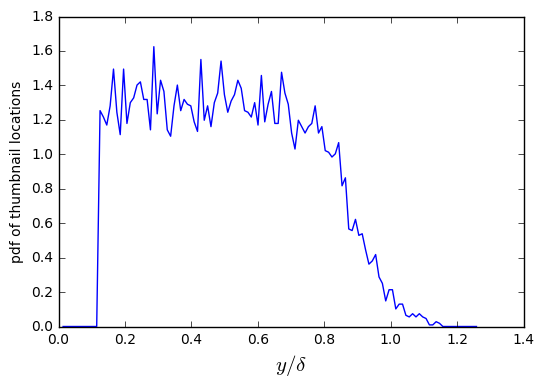

In [114]:
# Calcualte pdf of wall-normal locations
xedges = Y[:,0]/Cond["delta"]
xedges = np.concatenate([[xedges[0]-(xedges[1]-xedges[0])],xedges, [xedges[-1]+xedges[-1]-xedges[-2]]])
p, x = np.histogram(ypos/Cond["delta"], xedges,normed=True)
x = x[:-1] + (x[1] - x[0])/2 
plt.plot(x, p)
plt.xlabel('$y/\delta$', fontsize=15)
plt.ylabel('pdf of thumbnail locations')

plt.savefig(saveFolder + '/PDFswirl-Pro-10.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

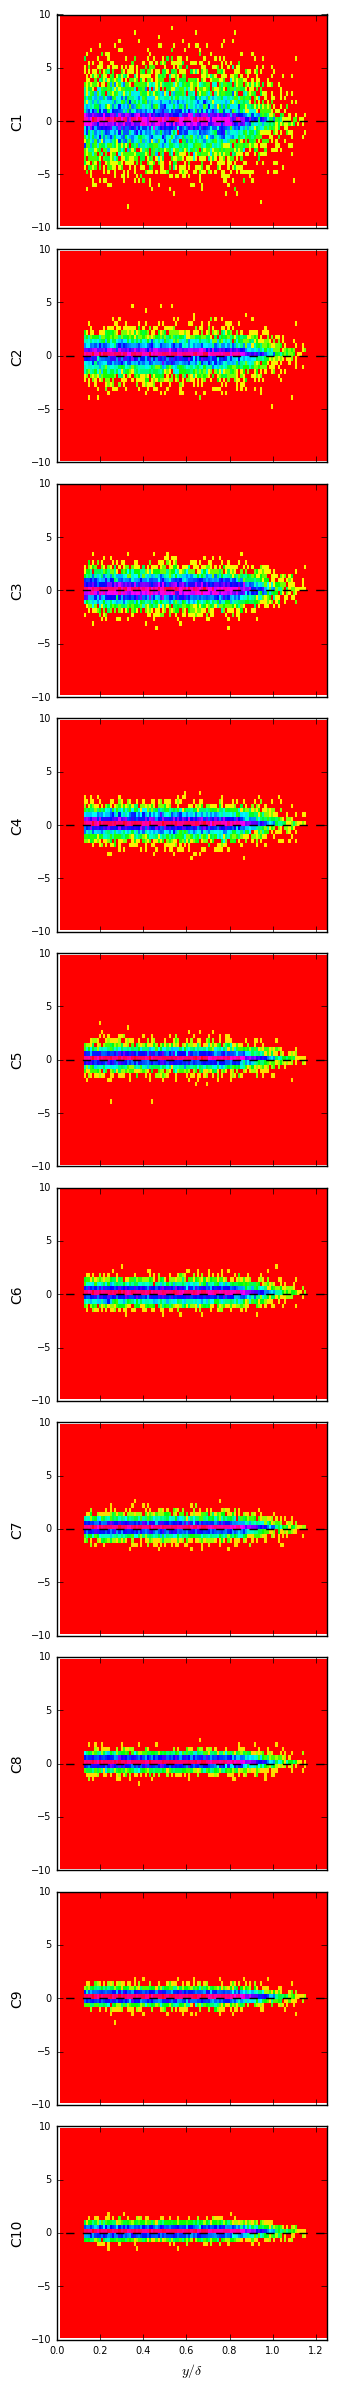

In [115]:
reload(PODutils)
C2 = C.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T/Cond["delta"], C2], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(10)),50,10,1,saveFolder)

# Do POD on retrograde swirl blobs (Box = 21x21)

In [102]:
#Set all NaNs to zero
Ut2[np.isnan(Ut2)] = 0
Vt2[np.isnan(Vt2)] = 0

uSize = Ut2.shape
#print(uSize)

In [35]:
uAll = np.concatenate((Ut2.reshape(uSize[0]*uSize[1],uSize[2]), Vt2.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0)
#uAll.shape      

In [36]:
import modred as mr

num_modes = 50;
modes, eig_vals = mr.compute_POD_matrices_snaps_method(uAll, list(range(num_modes)))

In [37]:
menergy = eig_vals/np.sum(eig_vals)
menergy_sum = np.zeros(len(menergy))
for i in range(len(menergy)):
    menergy_sum[i] = np.sum(menergy[:i]);

In [38]:
reload(PODutils)
Umodes, Vmodes= PODutils.reconstructPODmodes(modes,uSize,num_modes,2)

In [39]:
#Calculate the mode coefficients
C = modes.transpose()*uAll
C = np.asarray(C)

### Plot modal energy and contribution total

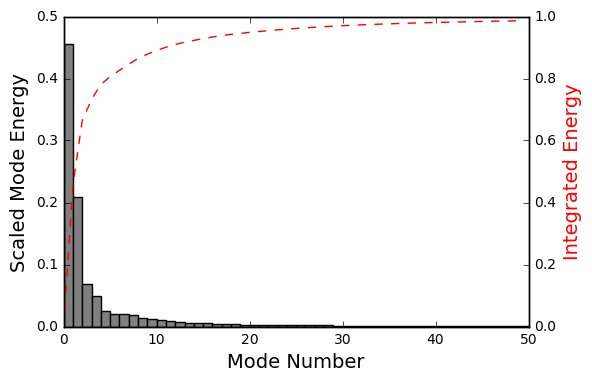

In [40]:
ind = np.arange(num_modes)  # the x locations for the groups
width = 1       # the width of the bars

f = plt.figure()
ax = plt.gca()
ax2 = plt.twinx()
rect = ax.bar(ind,menergy[:num_modes], width, color='gray')
line = ax2.plot(ind,menergy_sum[:num_modes],'--r')

ax.set_xlabel("Mode Number",fontsize=14)
ax.set_ylabel("Scaled Mode Energy",fontsize=14)
ax2.set_ylabel("Integrated Energy",fontsize=14,color='red')

f.savefig(saveFolder + '/ModeEnergy-Ret-10.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

### Plot some modes

/Users/Owen/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


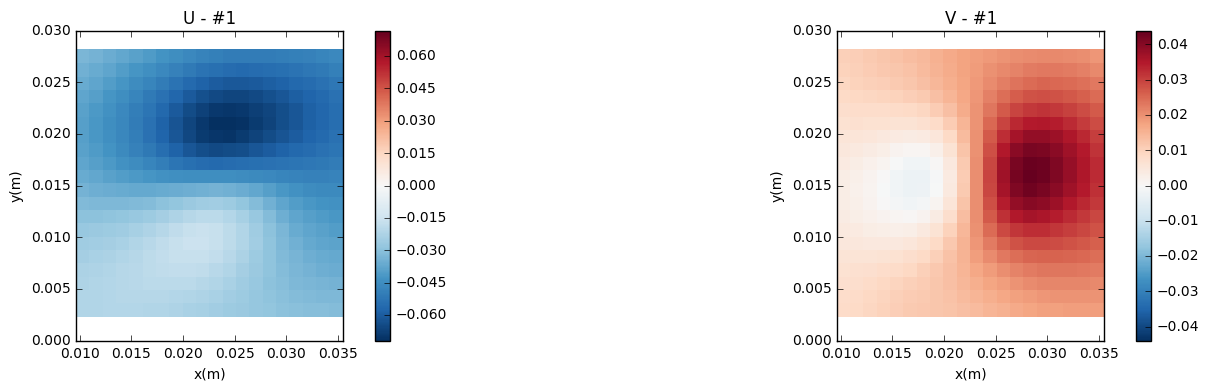

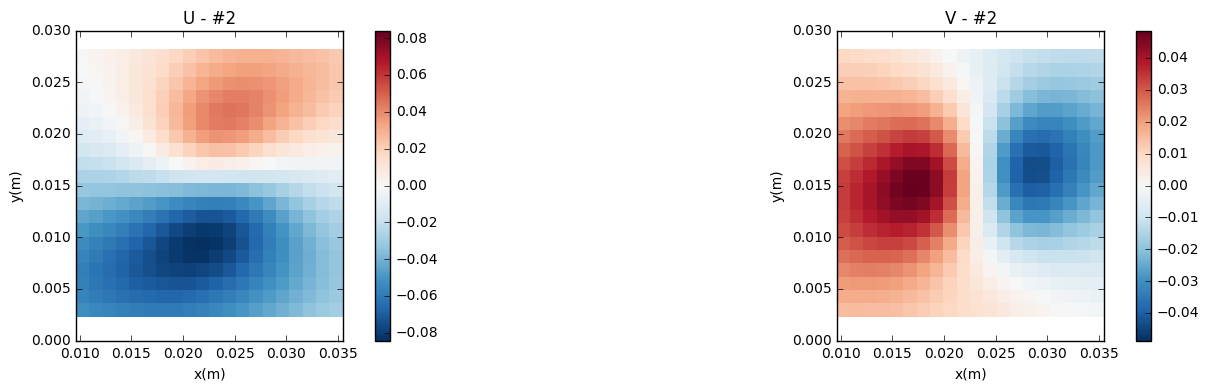

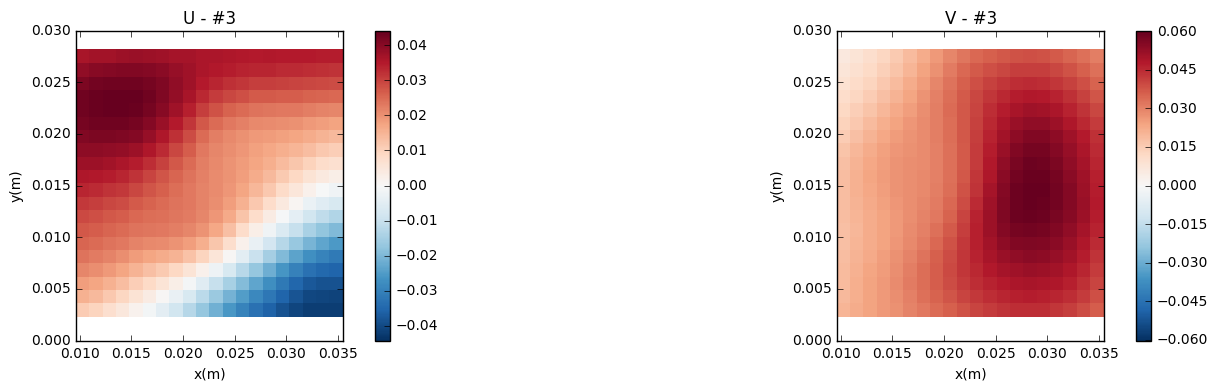

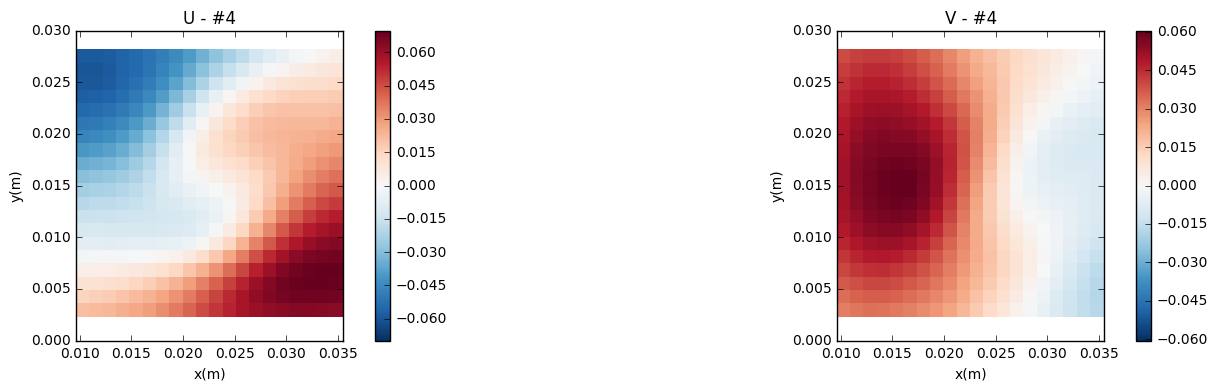

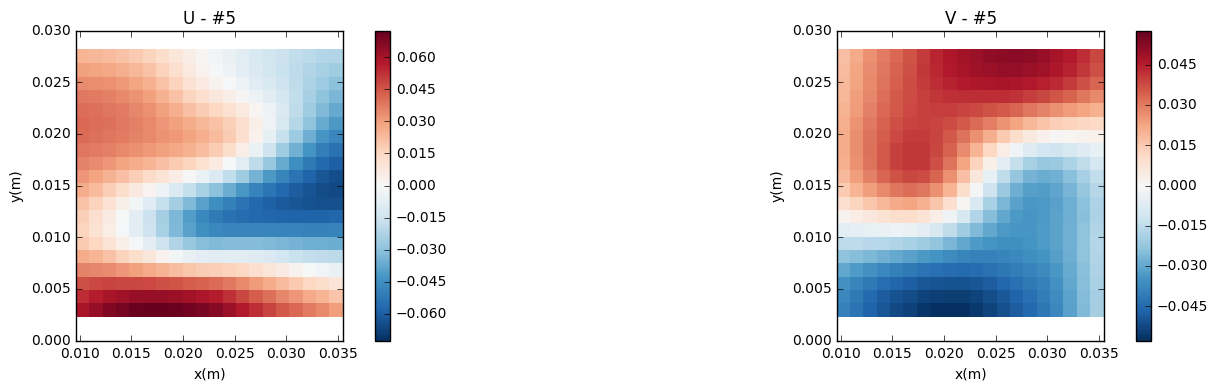

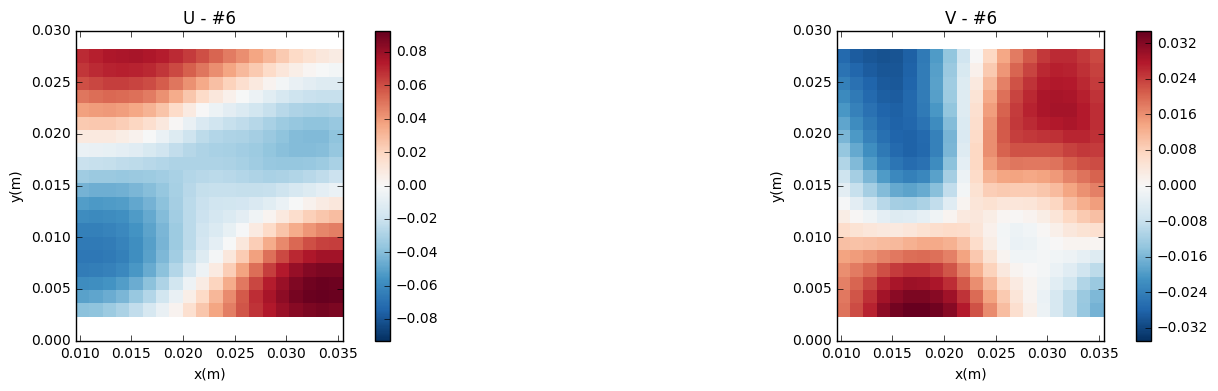

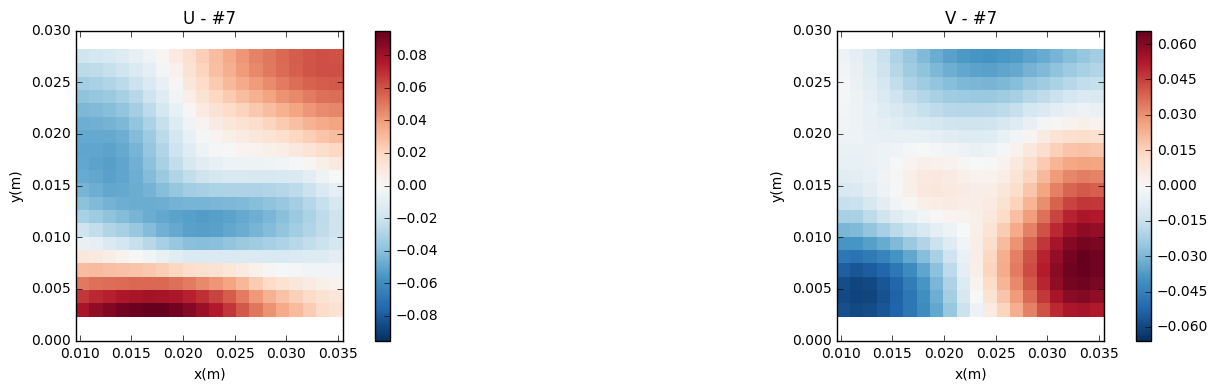

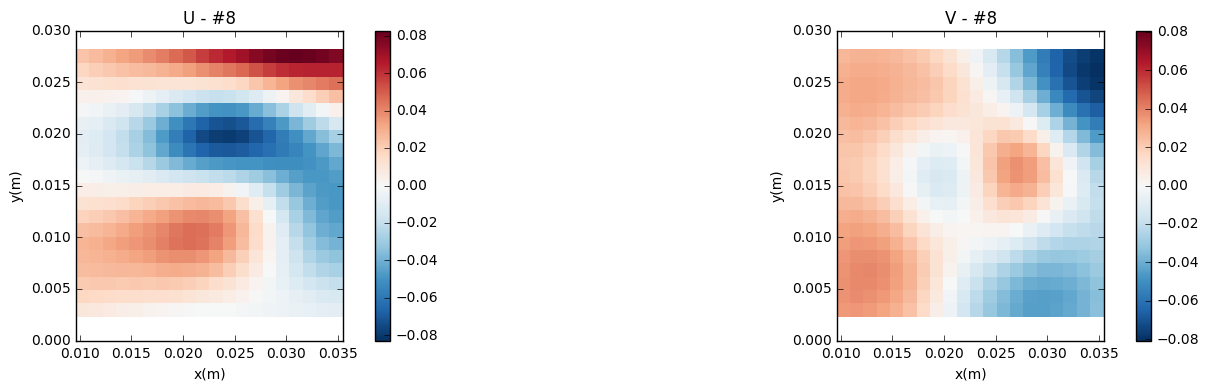

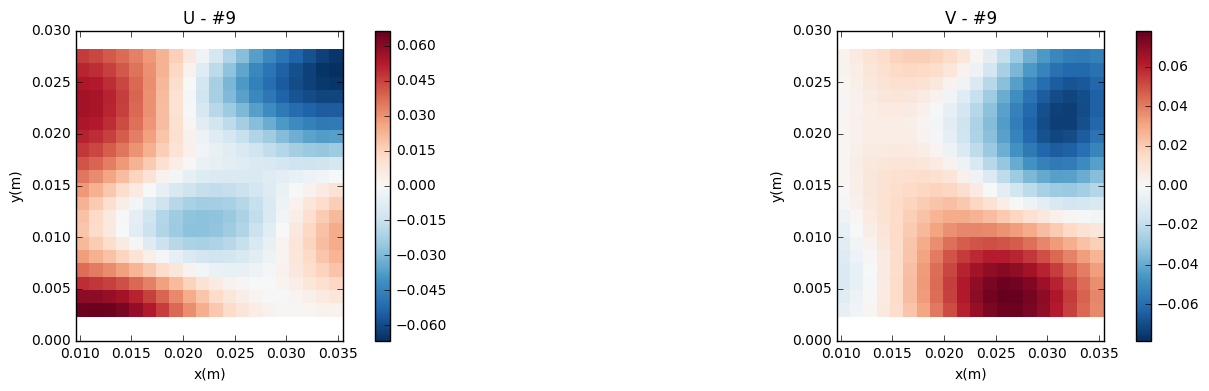

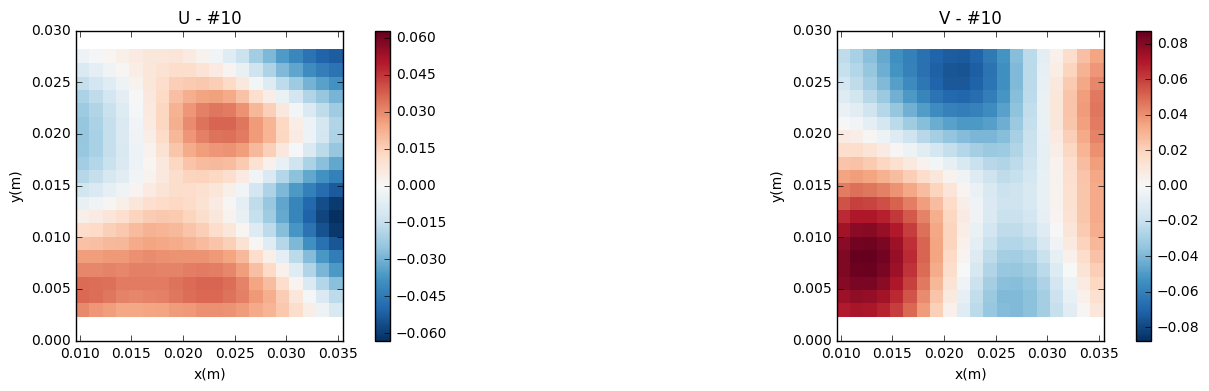

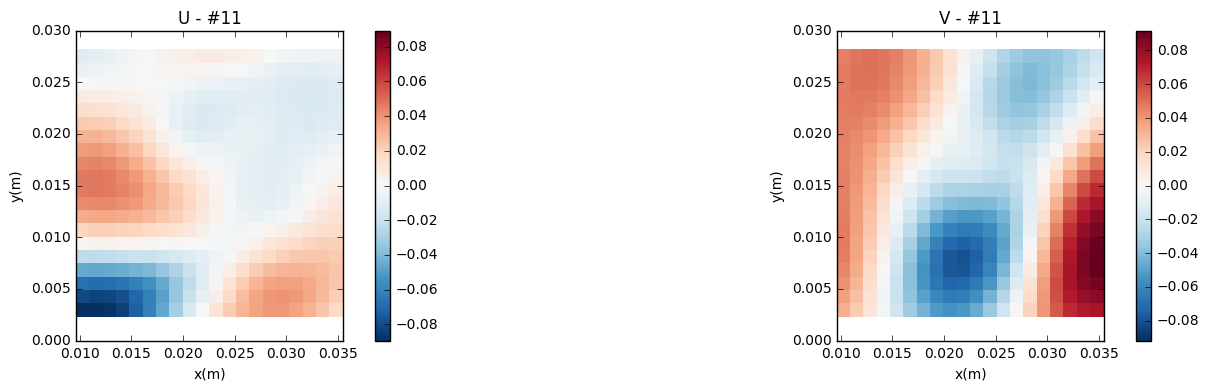

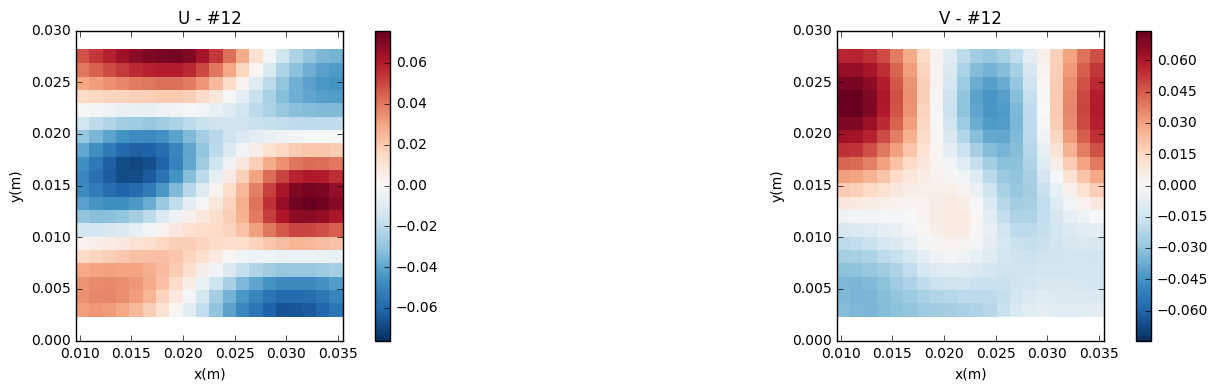

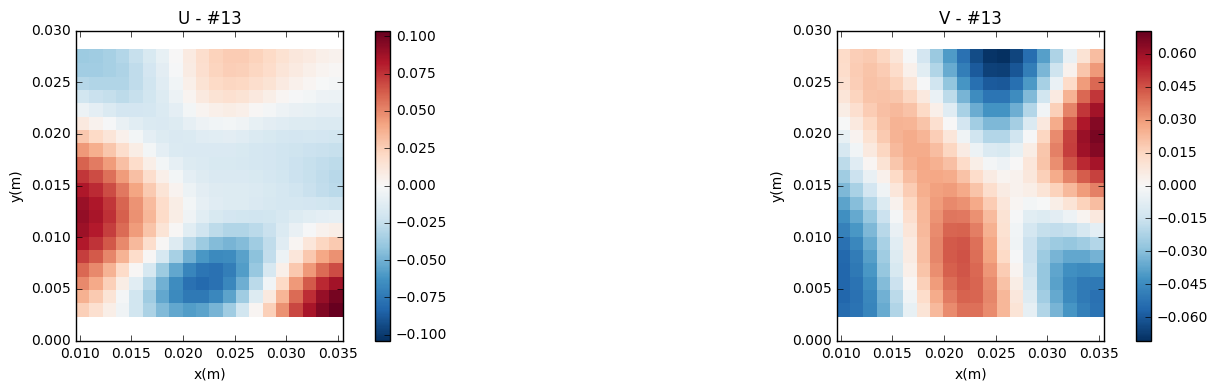

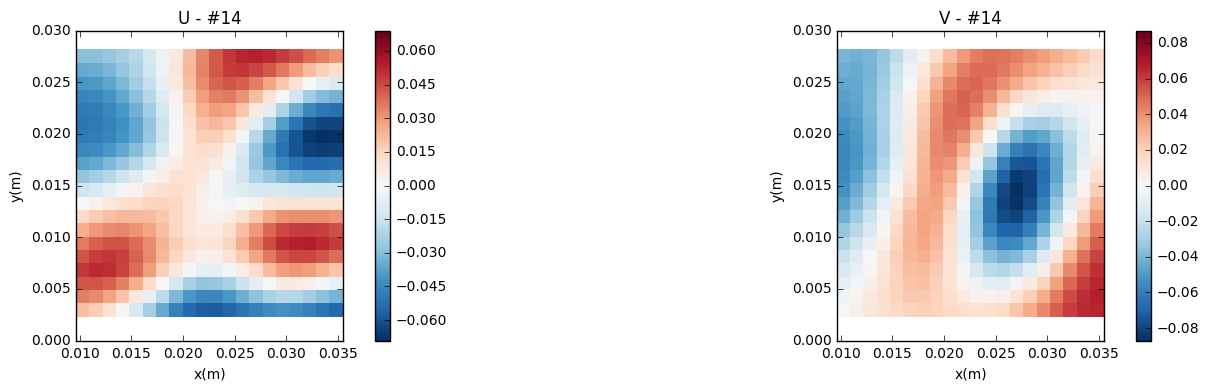

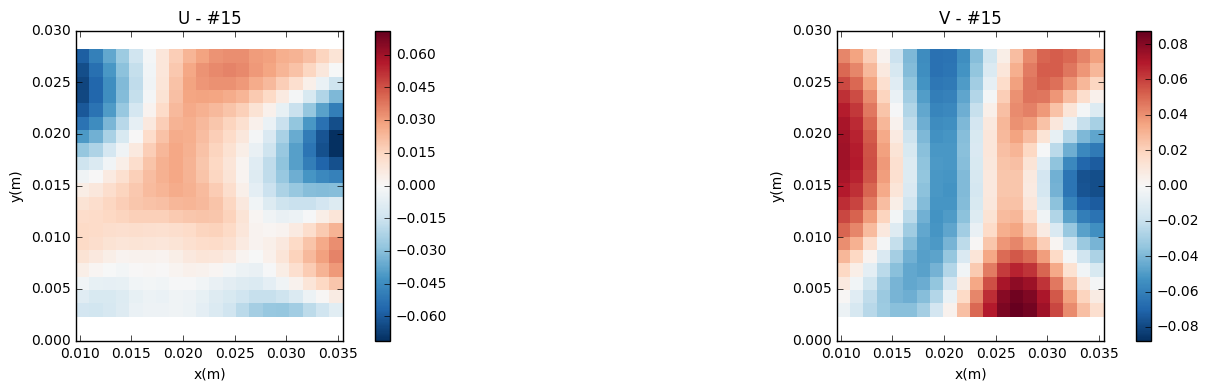

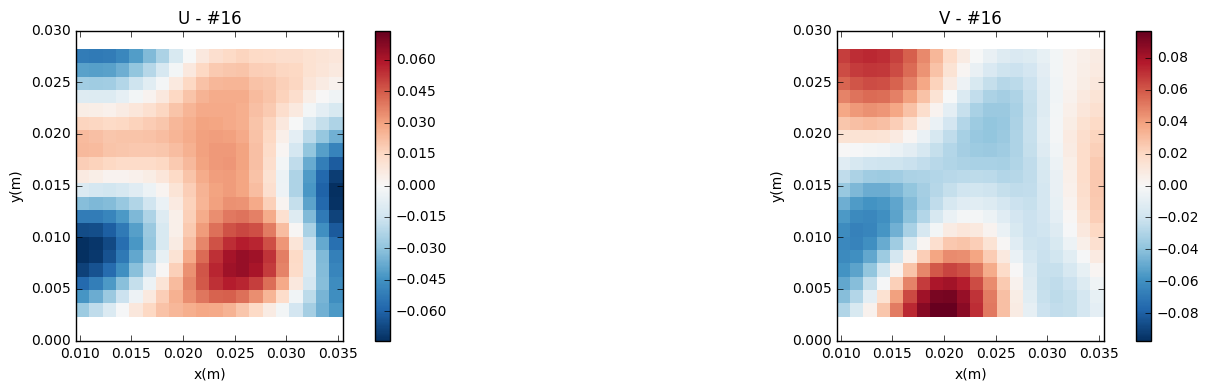

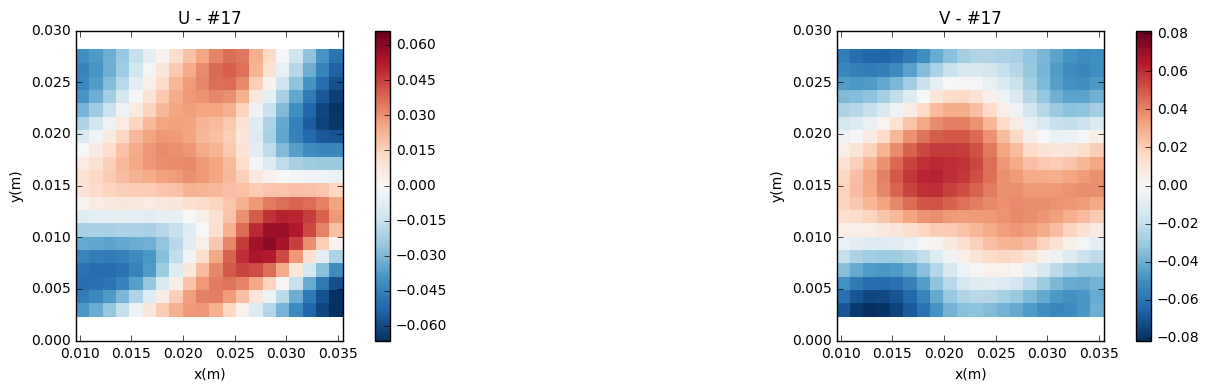

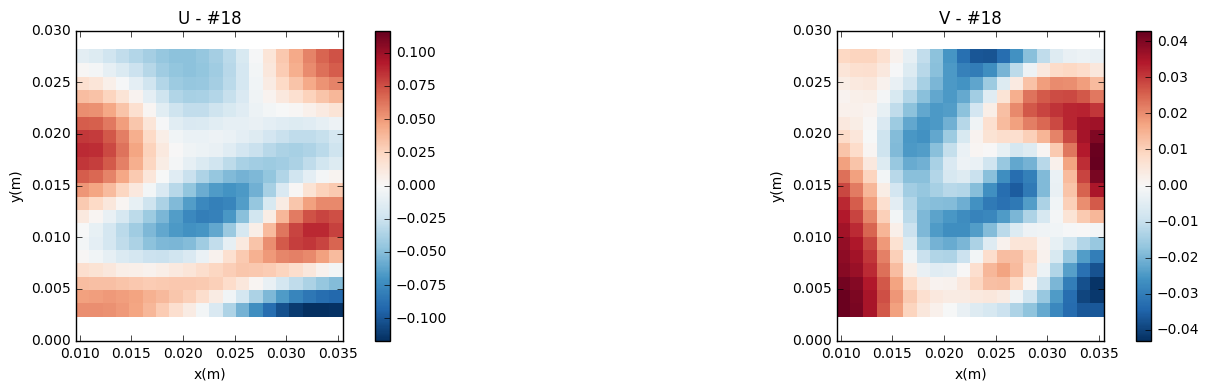

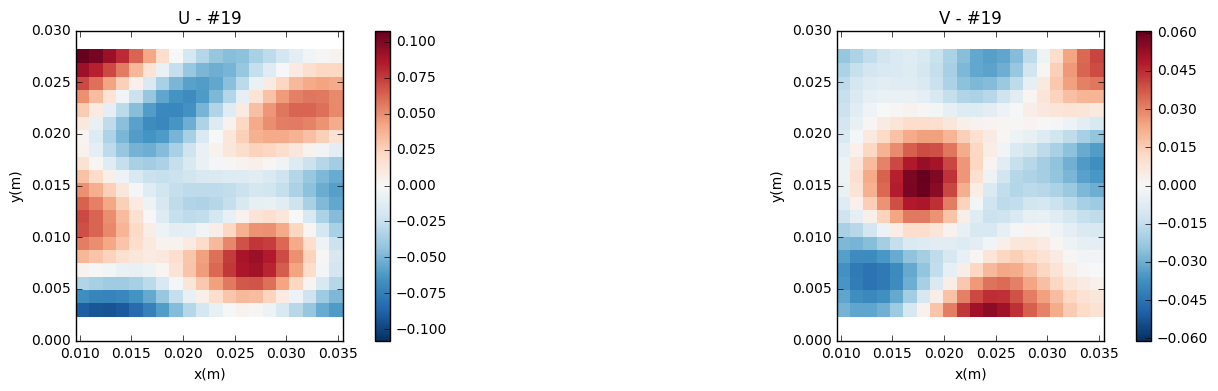

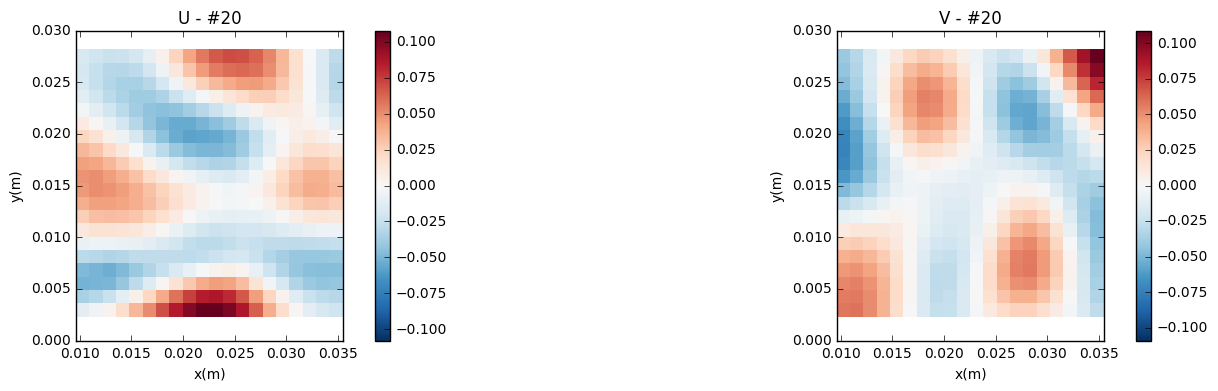

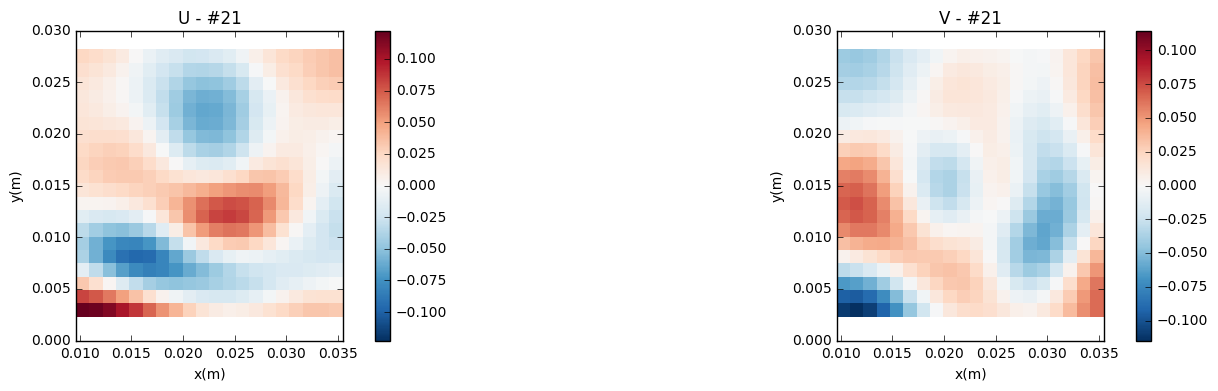

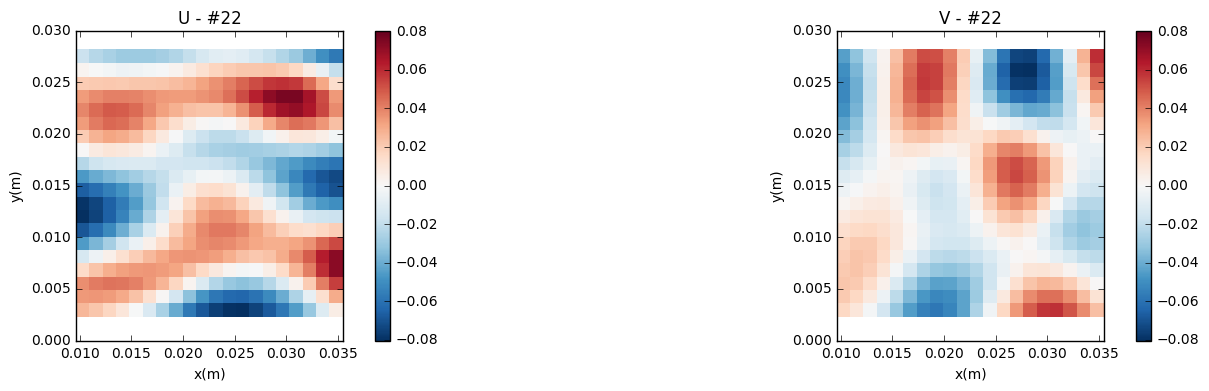

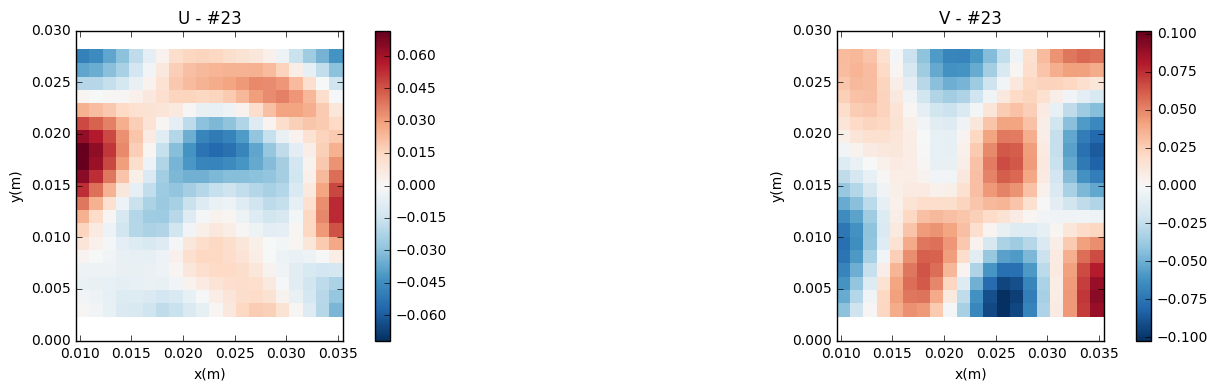

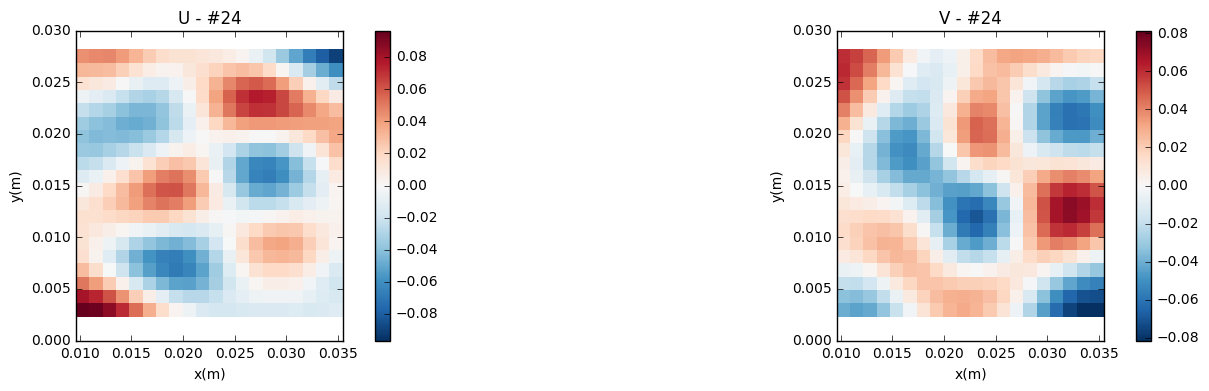

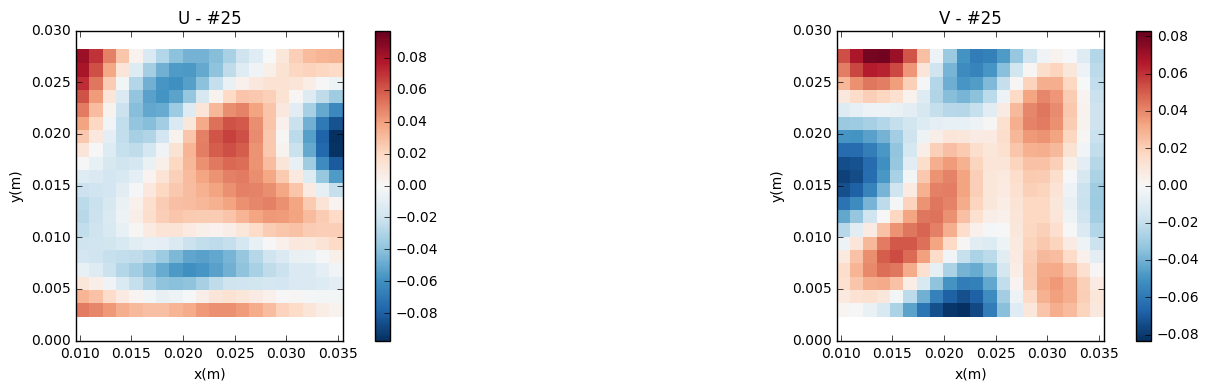

In [41]:
import PODutils
PODutils.plotPODmodes2D(X[:2*BoxSize+1,:2*BoxSize+1],Y[:2*BoxSize+1,:2*BoxSize+1],Umodes,Vmodes,list(range(25)))

### Plot the variation of the coefficients

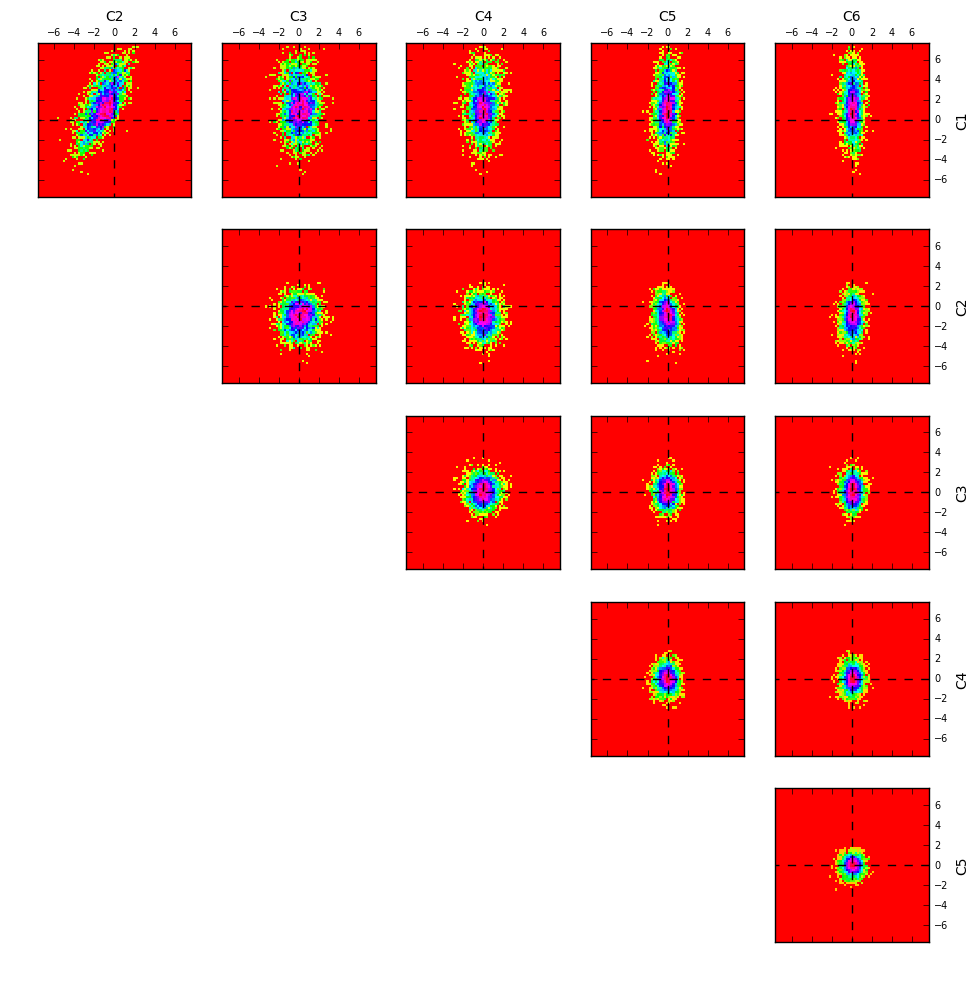

In [42]:
reload(PODutils)
PODutils.plotPODcoeff(C,list(range(6)),75,8,1)

In [43]:
ind = 0
ypos =[]
for i in range(len(cent_Ret)):
    for j in range(len(cent_Ret[i])):
        ypos = np.concatenate([ypos, [Y[cent_Ret[i][j][0],1]]])
        
        #[ind] = cent_Pro[i][j][0]*scale+Y[1,1]
        #ind+=1


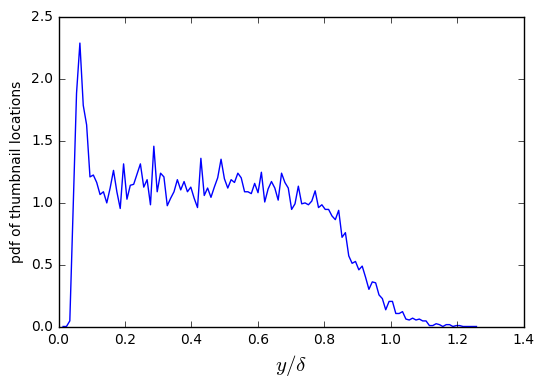

In [36]:
# Calcualte pdf of wall-normal locations
xedges = Y[:,0]/Cond["delta"]
xedges = np.concatenate([[xedges[0]-(xedges[1]-xedges[0])],xedges, [xedges[-1]+xedges[-1]-xedges[-2]]])
p, x = np.histogram(ypos/Cond["delta"], xedges,normed=True)
x = x[:-1] + (x[1] - x[0])/2 
plt.plot(x, p)
plt.xlabel('$y/\delta$', fontsize=15)
plt.ylabel('pdf of thumbnail locations')

plt.savefig(saveFolder + '/PDFswirl-Ret-10.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

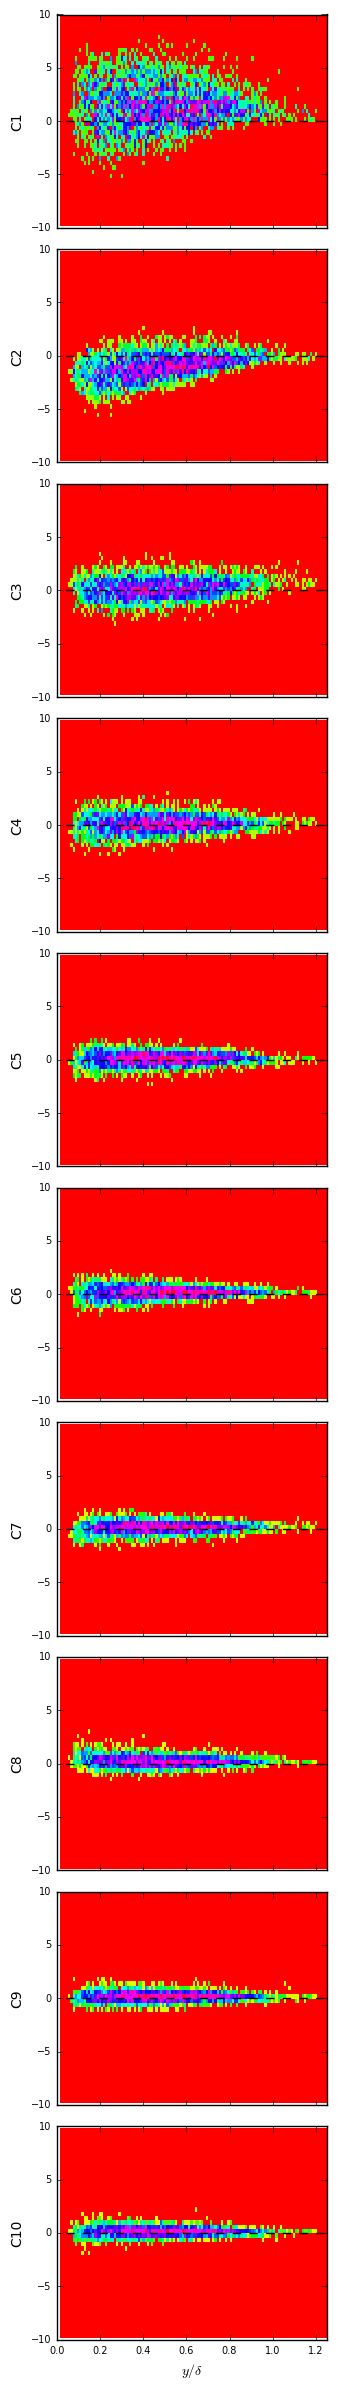

In [45]:
reload(PODutils)
C2 = C.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T/Cond["delta"], C2], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(10)),50,10,1)

# Get thumbnails (Box = 41x41)

In [46]:
reload(PIVutils)
BoxSize = 20

Ut, Vt, St = PIVutils.getThumbnails2D(Uf,Vf,Swirl,cent_Pro,BoxSize)
Ut2, Vt2, St2 = PIVutils.getThumbnails2D(Uf,Vf,Swirl,cent_Ret,BoxSize)

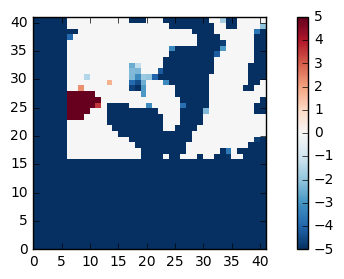

In [47]:
[f, ax] = PIVutils.plotScalarField(St[:,:,0],bound=5)

### Now do POD on the resulting thumbnails

In [48]:
#Set all NaNs to zero
Ut[np.isnan(Ut)] = 0
Vt[np.isnan(Vt)] = 0

uSize = Ut.shape

In [ ]:
uAll = np.concatenate((Ut.reshape(uSize[0]*uSize[1],uSize[2]), Vt.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0)
#uAll.shape      

In [ ]:
import modred as mr

num_modes = 50;
modes, eig_vals = mr.compute_POD_matrices_snaps_method(uAll, list(range(num_modes)))

In [ ]:
menergy = eig_vals/np.sum(eig_vals)
menergy_sum = np.zeros(len(menergy))
for i in range(len(menergy)):
    menergy_sum[i] = np.sum(menergy[:i]);

In [ ]:
reload(PODutils)
Umodes, Vmodes= PODutils.reconstructPODmodes(modes,uSize,num_modes,2)

In [ ]:
#Calculate the mode coefficients
C = modes.transpose()*uAll
C = np.asarray(C)

### Plot modal energy and contribution total

In [ ]:
ind = np.arange(num_modes)  # the x locations for the groups
width = 1       # the width of the bars

f = plt.figure()
ax = plt.gca()
ax2 = plt.twinx()
rect = ax.bar(ind,menergy[:num_modes], width, color='gray')
line = ax2.plot(ind,menergy_sum[:num_modes],'--r')

ax.set_xlabel("Mode Number",fontsize=14)
ax.set_ylabel("Scaled Mode Energy",fontsize=14)
ax2.set_ylabel("Integrated Energy",fontsize=14,color='red')

### Plot some modes

In [ ]:
import PODutils
PODutils.plotPODmodes2D(X[:2*BoxSize+1,:2*BoxSize+1],Y[:2*BoxSize+1,:2*BoxSize+1],Umodes,Vmodes,list(range(25)))

### Plot the variation of the coefficients

In [ ]:
reload(PODutils)
PODutils.plotPODcoeff(C,list(range(6)),100,8,1)

In [ ]:
ind = 0
ypos =[]
for i in range(len(cent_Pro)):
    for j in range(len(cent_Pro[i])):
        ypos = np.concatenate([ypos, [Y[cent_Pro[i][j][0],1]]])
        
        #[ind] = cent_Pro[i][j][0]*scale+Y[1,1]
        #ind+=1


In [ ]:
# Calcualte pdf of wall-normal locations
xedges = Y[:,0]/Cond["delta"]
xedges = np.concatenate([[xedges[0]-(xedges[1]-xedges[0])],xedges, [xedges[-1]+xedges[-1]-xedges[-2]]])
p, x = np.histogram(ypos/Cond["delta"], xedges,normed=True)
x = x[:-1] + (x[1] - x[0])/2 
plt.plot(x, p)
plt.xlabel('$y/\delta$', fontsize=15)
plt.ylabel('pdf of thumbnail locations')

In [ ]:
reload(PODutils)
C2 = C.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T/Cond["delta"], C], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(10)),50,10,1)

# Do POD on retrograde swirl blobs (Box = 41x41)

In [ ]:
#Set all NaNs to zero
Ut2[np.isnan(Ut2)] = 0
Vt2[np.isnan(Vt2)] = 0

uSize = Ut2.shape
#print(uSize)

In [ ]:
uAll = np.concatenate((Ut2.reshape(uSize[0]*uSize[1],uSize[2]), Vt2.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0)
#uAll.shape      

In [ ]:
import modred as mr

num_modes = 50;
modes, eig_vals = mr.compute_POD_matrices_snaps_method(uAll, list(range(num_modes)))

In [ ]:
menergy = eig_vals/np.sum(eig_vals)
menergy_sum = np.zeros(len(menergy))
for i in range(len(menergy)):
    menergy_sum[i] = np.sum(menergy[:i]);

In [ ]:
reload(PODutils)
Umodes, Vmodes= PODutils.reconstructPODmodes(modes,uSize,num_modes,2)

In [ ]:
#Calculate the mode coefficients
C = modes.transpose()*uAll
C = np.asarray(C)

### Plot modal energy and contribution total

In [ ]:
ind = np.arange(num_modes)  # the x locations for the groups
width = 1       # the width of the bars

f = plt.figure()
ax = plt.gca()
ax2 = plt.twinx()
rect = ax.bar(ind,menergy[:num_modes], width, color='gray')
line = ax2.plot(ind,menergy_sum[:num_modes],'--r')

ax.set_xlabel("Mode Number",fontsize=14)
ax.set_ylabel("Scaled Mode Energy",fontsize=14)
ax2.set_ylabel("Integrated Energy",fontsize=14,color='red')

### Plot some modes

In [ ]:
import PODutils
PODutils.plotPODmodes2D(X[:2*BoxSize+1,:2*BoxSize+1],Y[:2*BoxSize+1,:2*BoxSize+1],Umodes,Vmodes,list(range(25)))

### Plot the variation of the coefficients

In [ ]:
reload(PODutils)
PODutils.plotPODcoeff(C,list(range(6)),75,8,1)

In [ ]:
ind = 0
ypos =[]
for i in range(len(cent_Ret)):
    for j in range(len(cent_Ret[i])):
        ypos = np.concatenate([ypos, [Y[cent_Ret[i][j][0],1]]])
        
        #[ind] = cent_Pro[i][j][0]*scale+Y[1,1]
        #ind+=1


In [ ]:
# Calcualte pdf of wall-normal locations
xedges = Y[:,0]/Cond["delta"]
xedges = np.concatenate([[xedges[0]-(xedges[1]-xedges[0])],xedges, [xedges[-1]+xedges[-1]-xedges[-2]]])
p, x = np.histogram(ypos/Cond["delta"], xedges,normed=True)
x = x[:-1] + (x[1] - x[0])/2 
plt.plot(x, p)
plt.xlabel('$y/\delta$', fontsize=15)
plt.ylabel('pdf of thumbnail locations')

In [ ]:
reload(PODutils)
C2 = C.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T/Cond["delta"], C2], axis=0)
PODutils.plotYposPODcoeff(Y[:,0]/Cond["delta"],C2,list(range(10)),50,10,1)